목적: KBO 팀들의 2023년 팀률, 홈승률, 원정승률, 각팀간의 상대승률을 예측하는 모델 만들기

데이터 적용 방법:
- 크롤링과 자료수집을 통해 얻은 각종 팀 데이터를 수집함
- 수집한 데이터들을 전처리하여 최종 승부예측모델에 필요한 값들을 얻어내려고함

결론:
- 원하는 승률값들을 예측하는데는 성공해서 이후 승부예측모델의 데이터에 적용시킴
    
한계점:
- 이상치 처리나 데이터 엔지니어링을 확실하게 끝내지 못했기 때문에(데이터에 대한 이해가 조금 부족했음) 생각보다 낮은 예측점수가 나왔음(여러번 방법을 바꿔가며 valid의 R2score가 가장 높은 데이터를 선택했음)
- target이 13개로 상당히 많은편이었기 때문에 기존에 다뤄보지 못한 데이터 예측이라서 방법을 찾는데 시간을 많이 소비함


팀단위 계획

목표: 1. 승패예측 모델 만들기
      2. 가상의 팀 구성

현재 1단계 진행중

어려운 점: 우리가 가지고있는 데이터로 어떻게 승부예측 모델을 만들것인가..(처음에는 선수 데이터와 팀 데이터를 대충 때려넣으면 될줄알았는데 하다보니까 어떤방식으로 학습을 시켜야할지 막막했다. 찾아봐도 방법도 각양 각색이고 두가지 데이터를 학습시키는 방식으로 구현한게 많아서 따라해보려했는데 배우지도 않았을뿐더러, 상세하게 설명된 논문이나 자료가 없었기 때문에 접근방식이 너무 막막했다.

현재 접근방향(중간회고): 선수가 아닌 팀 성적만으로 승무패 예측하는 쪽으로 가는중 , 이후 선수데이터는 가상의 팀을 구성할때 활용하는게 어떨까?

결론: 팀 데이터에서 팀승률, 홈승률, 원정승률, 각팀간의 상대승률을 target으로 예측값을 얻자.
    선수 데이터를 담당하는 사람의 데이터에서도 각각 예측값을 얻은 후 승부예측 모델을 완성하자.

# 데이터 불러오기

In [1]:
import zipfile
import pandas as pd
import numpy as np
import seaborn as sns
import glob
import os
import matplotlib.pyplot as plt
import koreanize_matplotlib
%config InlineBackend.figure_format = 'retina'

In [2]:
# # zip 파일 열기
# with zipfile.ZipFile('data.zip', 'r') as zip_ref:
#     # zip 파일 내의 모든 파일 읽어들이기
#     dfs = []
#     for name in zip_ref.namelist():
#         if name.endswith('.csv'):
#             # csv 파일만 읽어들이기
#             with zip_ref.open(name) as file:
#                 df = pd.read_csv(file)
#                 dfs.append(df)
# # 모든 데이터 프레임을 합치기
# df = pd.concat(dfs)
# df

## 선수 개인성적 데이터 불러오기(스탯티즈 선수기록실 크롤링)

In [3]:
# 파일 경로 설정
data_folder = 'data'
file_names = os.listdir(data_folder)

# 파일 이름에서 필요한 문자열을 추출하여 데이터프레임 만들기
df_defence = pd.concat([pd.read_csv(os.path.join(data_folder, file_name)) for file_name in file_names if 'defence' in file_name])
df_hit = pd.concat([pd.read_csv(os.path.join(data_folder, file_name)) for file_name in file_names if 'hit' in file_name])
df_pitch = pd.concat([pd.read_csv(os.path.join(data_folder, file_name)) for file_name in file_names if 'pitch' in file_name])
df_total = pd.concat([pd.read_csv(os.path.join(data_folder, file_name)) for file_name in file_names if 'total' in file_name])

## 데이터 확인 및 결측치 제거

### 선수 수비 데이터

In [4]:
df_defence.head()

,팀,이름,WAAwithADJ,출장,선발,이닝,기회,자살,보살,실책,...,E+,RAA,/133,POSADJ,RAAwithADJ,WAAw/oADJ,순위,ARM,CS,BLK
0,KIA,가뇽,0.185,2,28.0,159.2,26,8,18.0,0.0,...,0.32,1.96,14.67,0.00,1.96,0.185,NaN,NaN,NaN,NaN
1,KIA,고영창,-0.061,2,0.0,58.0,10,2,7.0,1.0,...,-0.08,-0.64,-13.28,0.00,-0.64,-0.061,NaN,NaN,NaN,NaN
2,KIA,김규성,0.238,113,69.0,798.4,464,200,252.0,12.0,...,-0.25,0.92,-8.54,1.66,2.59,0.077,NaN,NaN,NaN,NaN
3,KIA,김기훈,-0.098,1,7.0,52.0,7,1,4.0,2.0,...,-0.30,-1.05,-24.11,0.00,-1.05,-0.098,NaN,NaN,NaN,NaN
4,KIA,김도영,0.134,90,60.0,567.2,219,76,130.0,13.0,...,-0.75,-0.17,-0.37,1.47,1.29,-0.018,NaN,NaN,NaN,NaN


In [5]:
df_defence.columns

Index(['팀', '이름', 'WAAwithADJ', '출장', '선발', '이닝', '기회', '자살', '보살', '실책',
       '수비율', 'RF9', 'RNG', 'E+', 'RAA', '/133', 'POSADJ', 'RAAwithADJ',
       'WAAw/oADJ', '순위', 'ARM', 'CS', 'BLK'],
      dtype='object')

In [6]:
df_defence.isnull().sum()

팀               0
이름              0
WAAwithADJ      0
출장              0
선발              0
이닝              0
기회              0
자살              0
보살              0
실책              0
수비율             0
RF9             0
RNG             0
E+              0
RAA             0
/133            0
POSADJ          0
RAAwithADJ      0
WAAw/oADJ       0
순위            598
ARM           561
CS            561
BLK           561
dtype: int64

In [7]:
df_defence['팀'].unique()

array(['KIA', 'LG', 'NC', 'SK', 'SSG', 'kt', '두산', '롯데', '삼성', '키움', '한화',
       '20롯SS', '20LSS', '20삼CF', '20KSS', '20NC', '20LCF', '20LC',
       '20삼C', '20키2B', '20키SS', '20KCF', '20KC', '20한C', '20롯3B',
       '20K2B', '20N2B', '20SRF', '20두C', '20두CF', '20키C', '20SC', '20롯C',
       '20두SS', '20KLF', '20NSS', '20키3B', '20SCF', '20삼SS', '20두3B',
       '20L3B', '20삼LF', '20한1B', '20N3B', '20S3B', '20키RF', '20NRF',
       '20SSS', '20S2B', '20삼RF', '20키CF', '20삼2B', '20KP', '20K3B',
       '20두2B', '20한3B', '20두SC', '20LP', '20한SS', '20SP', '20키P', '20삼P',
       '20롯P', '20두P', '20한P', '20한LF', '20두RF', '20삼3B', '20K1B',
       '20NK3B', '20NP', '20NCF', '20LRF', '20L1B', '20두LF', '20롯CF',
       '20한2B', '20SKC', '20롯1B', '20NLF', '20KNP', '20KK2B', '20NKP',
       '20S1B', '20두1B', '20L2B', '20롯DH', '20SLF', '20삼1B', '20롯RF',
       '20두K3B', '20키LF', '20K두P', '20한SP', '20KRF', '20한RF', '20키1B',
       '20한CF', '20S한CF', '20KSLF', '20롯LF', '20N1B', '20SDH', '20롯2B',
       '20

In [8]:
# 공동순위의 경우 아래있는 순위는 위와 같지만 빈칸이 되므로 fillna(method='ffill')를 통해 채워줌

df_defence['순위'] = df_defence['순위'].fillna(method='ffill')

In [9]:
df_defence[df_defence.isnull().any(axis=1)]

,팀,이름,WAAwithADJ,출장,선발,이닝,기회,자살,보살,실책,...,E+,RAA,/133,POSADJ,RAAwithADJ,WAAw/oADJ,순위,ARM,CS,BLK
0,KIA,가뇽,0.185,2,28.0,159.2,26,8,18.0,0.0,...,0.32,1.96,14.67,0.00,1.96,0.185,NaN,NaN,NaN,NaN
1,KIA,고영창,-0.061,2,0.0,58.0,10,2,7.0,1.0,...,-0.08,-0.64,-13.28,0.00,-0.64,-0.061,NaN,NaN,NaN,NaN
2,KIA,김규성,0.238,113,69.0,798.4,464,200,252.0,12.0,...,-0.25,0.92,-8.54,1.66,2.59,0.077,NaN,NaN,NaN,NaN
3,KIA,김기훈,-0.098,1,7.0,52.0,7,1,4.0,2.0,...,-0.30,-1.05,-24.11,0.00,-1.05,-0.098,NaN,NaN,NaN,NaN
4,KIA,김도영,0.134,90,60.0,567.2,219,76,130.0,13.0,...,-0.75,-0.17,-0.37,1.47,1.29,-0.018,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
556,한화,페레즈,-0.072,53,54.0,465.0,273,200,63.0,10.0,...,-1.01,0.91,2.34,-1.63,-0.72,0.091,NaN,NaN,NaN,NaN
557,한화,하주석,2.015,222,282.0,2381.2,1053,357,654.0,42.0,...,0.40,7.40,6.3,12.24,19.63,0.791,NaN,NaN,NaN,NaN
558,한화,허관회,-0.037,17,9.0,94.0,78,74,3.0,1.0,...,-0.06,-1.17,-14.88,0.80,-0.37,-0.117,NaN,NaN,NaN,NaN
559,한화,호잉,-0.298,2,33.0,278.0,73,71,2.0,0.0,...,0.17,-1.62,-6.98,-1.49,-3.11,-0.155,NaN,NaN,NaN,NaN


In [10]:
df_defence = df_defence.dropna()
df_defence[df_defence.isnull().any(axis=1)]

,팀,이름,WAAwithADJ,출장,선발,이닝,기회,자살,보살,실책,...,E+,RAA,/133,POSADJ,RAAwithADJ,WAAw/oADJ,순위,ARM,CS,BLK


### 선수 타격 데이터

In [11]:
df_hit.head(2)

,팀,이름,WAR,G,타석,타수,득점,안타,2타,3타,...,타율,출루,장타,OPS,wOBA,wRC+,WAR*,WPA,순위,희비
0,KIA,고종욱,0.40,62,114,106,13,30,7,1,...,0.283,0.327,0.425,0.752,0.341,110.4,0.40,0.63,NaN,NaN
1,KIA,김규성,-1.53,227,275,243,43,42,3,2,...,0.497,0.686,0.708,1.394,0.655,59.4,-1.53,-2.93,NaN,NaN


In [12]:
df_hit.columns

Index(['팀', '이름', 'WAR', 'G', '타석', '타수', '득점', '안타', '2타', '3타', '홈런', '루타',
       '타점', '도루', '도실', '볼넷', '사구', '고4', '삼진', '병살', '희타', '타율', '출루', '장타',
       'OPS', 'wOBA', 'wRC+', 'WAR*', 'WPA', '순위', '희비'],
      dtype='object')

In [13]:
df_hit.columns.isnull().sum()

0

### 선수 투구 데이터

In [14]:
df_pitch.head(2)

,팀,이름,WAR,출장,완투,완봉,선발,승,패,세이브,...,삼진,보크,폭투,WPA,순위,ERA,FIP,WHIP,ERA+,FIP+
0,KIA,가뇽,2.84,28,0,0,28,11,8,0,...,141,0,13,-0.55,NaN,NaN,NaN,NaN,NaN,NaN
1,KIA,고영창,0.63,99,0,0,0,1,4,1,...,38,2,6,-1.54,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
df_pitch.columns

Index(['팀', '이름', 'WAR', '출장', '완투', '완봉', '선발', '승', '패', '세이브', '홀드', '이닝',
       '실점', '자책', '타자', '안타', '2타', '3타', '홈런', '볼넷', '고4', '사구', '삼진', '보크',
       '폭투', 'WPA', '순위', 'ERA', 'FIP', 'WHIP', 'ERA+', 'FIP+'],
      dtype='object')

In [16]:
df_pitch['순위'] = df_pitch['순위'].fillna(method='ffill')

In [17]:
df_pitch[df_pitch.isnull().any(axis=1)]

,팀,이름,WAR,출장,완투,완봉,선발,승,패,세이브,...,삼진,보크,폭투,WPA,순위,ERA,FIP,WHIP,ERA+,FIP+
0,KIA,가뇽,2.84,28,0,0,28,11,8,0,...,141,0,13,-0.55,NaN,NaN,NaN,NaN,NaN,NaN
1,KIA,고영창,0.63,99,0,0,0,1,4,1,...,38,2,6,-1.54,NaN,NaN,NaN,NaN,NaN,NaN
2,KIA,김기훈,0.81,27,0,0,7,0,4,0,...,48,0,3,-0.84,NaN,NaN,NaN,NaN,NaN,NaN
3,KIA,김도현,-0.06,4,0,0,2,0,1,0,...,11,0,0,-0.28,NaN,NaN,NaN,NaN,NaN,NaN
4,KIA,김명찬,-0.07,21,0,0,0,0,1,0,...,11,0,4,-1.53,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,한화,카펜터,2.65,35,0,0,34,5,13,0,...,194,1,8,0.73,NaN,NaN,NaN,NaN,NaN,NaN
503,한화,킹엄,4.13,28,0,0,28,11,10,0,...,149,2,4,1.78,NaN,NaN,NaN,NaN,NaN,NaN
504,한화,페냐,0.58,13,0,0,13,5,4,0,...,72,0,4,0.15,NaN,NaN,NaN,NaN,NaN,NaN
505,한화,한승주,-0.22,8,0,0,3,0,0,0,...,14,0,0,-0.33,NaN,NaN,NaN,NaN,NaN,NaN


### 선수 종합(war기준) 데이터

In [18]:
print(df_total.shape)
df_total.sample(5)

(2090, 16)


,순위,이름,팀,WAR,타격,도루,주루,수비,Rep.Wins,Pos.Wins,WAA_투수_선발,WAA_투수_구원,Rep.wins_선발,Rep.wins_구원,WAR_투수_선발,WAR_투수_구원
140,141.0,오윤석,20롯2B,0.95,0.40,-0.01,0.14,-0.36,0.82,-0.04,0.00,0.00,0.00,0.00,0.00,0.00
182,NaN,홍현빈,22KRF,0.58,-0.45,0.08,0.05,0.63,0.38,-0.10,0.00,0.00,0.00,0.00,0.00,0.00
485,NaN,박종기,21두P,-0.23,0.00,0.00,0.00,0.00,0.00,0.00,-0.79,-0.23,0.26,0.53,-0.53,0.30
153,154.0,박치국,23두P,0.14,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.14,0.00,0.14
138,139.0,우규민,21삼P,1.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.37,0.00,0.65,0.00,1.02


In [19]:
df_total.head(2)

,순위,이름,팀,WAR,타격,도루,주루,수비,Rep.Wins,Pos.Wins,WAA_투수_선발,WAA_투수_구원,Rep.wins_선발,Rep.wins_구원,WAR_투수_선발,WAR_투수_구원
0,1.0,알칸타라,20두P,8.31,0.00,0.00,0.00,0.00,0.00,0.00,5.66,0.0,2.65,0.0,8.31,0.0
1,2.0,로하스,20KRF,7.95,6.04,-0.05,0.06,0.19,2.62,-0.91,0.00,0.0,0.00,0.0,0.00,0.0


In [20]:
df_total.columns, df_total.shape

(Index(['순위', '이름', '팀', 'WAR', '타격', '도루', '주루', '수비', 'Rep.Wins', 'Pos.Wins',
        'WAA_투수_선발', 'WAA_투수_구원', 'Rep.wins_선발', 'Rep.wins_구원', 'WAR_투수_선발',
        'WAR_투수_구원'],
       dtype='object'),
 (2090, 16))

In [21]:
df_total.isnull().sum()

순위             1151
이름                0
팀                 0
WAR               0
타격                0
도루                0
주루                0
수비                0
Rep.Wins          0
Pos.Wins          0
WAA_투수_선발         0
WAA_투수_구원         0
Rep.wins_선발       0
Rep.wins_구원       0
WAR_투수_선발         0
WAR_투수_구원         0
dtype: int64

In [22]:
df_total.head(2)

,순위,이름,팀,WAR,타격,도루,주루,수비,Rep.Wins,Pos.Wins,WAA_투수_선발,WAA_투수_구원,Rep.wins_선발,Rep.wins_구원,WAR_투수_선발,WAR_투수_구원
0,1.0,알칸타라,20두P,8.31,0.00,0.00,0.00,0.00,0.00,0.00,5.66,0.0,2.65,0.0,8.31,0.0
1,2.0,로하스,20KRF,7.95,6.04,-0.05,0.06,0.19,2.62,-0.91,0.00,0.0,0.00,0.0,0.00,0.0


In [23]:
df_total['순위'] = df_total['순위'].fillna(method='ffill')

In [24]:
df_total[df_total.isnull().any(axis=1)]

,순위,이름,팀,WAR,타격,도루,주루,수비,Rep.Wins,Pos.Wins,WAA_투수_선발,WAA_투수_구원,Rep.wins_선발,Rep.wins_구원,WAR_투수_선발,WAR_투수_구원


## 선수 데이터를 타자 / 투수로 구분하기

In [25]:
# '이름'에 P가 포함되면 투수, 아니면 타자로 구분함

df_defence['포지션'] = df_defence['팀'].apply(lambda x: '투수' if 'P' in x else '타자')
df_hit['포지션'] = df_hit['팀'].apply(lambda x: '투수' if 'P' in x else '타자')
df_total['포지션'] = df_total['팀'].apply(lambda x: '투수' if 'P' in x else '타자')
df_pitch['포지션'] = df_pitch['팀'].apply(lambda x: '투수' if 'P' in x else '타자')

In [26]:
# 그리고 각 선수 데이터를 타자, 투수로 나눴음

df_defence_hit = df_defence[df_defence['포지션'] == '타자']
df_defence_pit = df_defence[df_defence['포지션'] == '투수']
df_hit_hit = df_hit[df_hit['포지션'] == '타자']
df_hit_pit = df_hit[df_hit['포지션'] == '투수']
df_total_hit = df_total[df_total['포지션'] == '타자']
df_total_pit = df_total[df_total['포지션'] == '투수']
df_pitch_hit = df_pitch[df_pitch['포지션'] == '타자']
df_pitch_pit = df_pitch[df_pitch['포지션'] == '투수']

In [27]:
# 그리고 전체 선수 데이터를 타자, 투수 2분류로 묶었음

df_hit = pd.concat([df_hit_hit, df_total_hit, df_pitch_hit, df_defence_hit])
df_pit = pd.concat([df_hit_pit, df_total_pit, df_pitch_pit, df_defence_pit])

In [28]:
df_hit.sample(2)

,팀,이름,WAR,G,타석,타수,득점,안타,2타,3타,...,RNG,E+,RAA,/133,POSADJ,RAAwithADJ,WAAw/oADJ,ARM,CS,BLK
143,21한1B,힐리,0.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89,NC,손아섭,2.07,138.0,617.0,548.0,72.0,152.0,29.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
df_hit.columns

Index(['팀', '이름', 'WAR', 'G', '타석', '타수', '득점', '안타', '2타', '3타', '홈런', '루타',
       '타점', '도루', '도실', '볼넷', '사구', '고4', '삼진', '병살', '희타', '타율', '출루', '장타',
       'OPS', 'wOBA', 'wRC+', 'WAR*', 'WPA', '순위', '희비', '포지션', '타격', '주루',
       '수비', 'Rep.Wins', 'Pos.Wins', 'WAA_투수_선발', 'WAA_투수_구원', 'Rep.wins_선발',
       'Rep.wins_구원', 'WAR_투수_선발', 'WAR_투수_구원', '출장', '완투', '완봉', '선발', '승',
       '패', '세이브', '홀드', '이닝', '실점', '자책', '타자', '보크', '폭투', 'ERA', 'FIP',
       'WHIP', 'ERA+', 'FIP+', 'WAAwithADJ', '기회', '자살', '보살', '실책', '수비율',
       'RF9', 'RNG', 'E+', 'RAA', '/133', 'POSADJ', 'RAAwithADJ', 'WAAw/oADJ',
       'ARM', 'CS', 'BLK'],
      dtype='object')

In [30]:
df_pit.sample(10)

,팀,이름,WAR,G,타석,타수,득점,안타,2타,3타,...,RNG,E+,RAA,/133,POSADJ,RAAwithADJ,WAAw/oADJ,ARM,CS,BLK
380,22두P,이현승,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.37,0.02,-0.35,-47.78,0.0,-0.35,-0.036,0.0,0.0,0.00
534,22NP,이용준,-0.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
145,21한P,김종수,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.34,0.09,0.45,11.54,0.0,0.45,0.045,0.0,0.0,0.02
144,23키P,김재웅,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.04,0.02,0.06,10.44,0.0,0.06,0.007,0.0,0.0,0.00
259,21두P,김명신,0.00,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
524,21LP,김대유,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.40,-0.31,-1.68,-39.67,0.0,-1.68,-0.167,0.0,0.0,0.02
116,21SP,폰트,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.58,0.07,0.71,5.87,0.0,0.71,0.071,0.0,0.0,0.06
161,23KP,조이현,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.03,0.03,3.41,0.0,0.03,0.003,0.0,0.0,0.01
167,22삼P,홍정우,0.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
323,22롯P,문경찬,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.24,0.10,-0.12,-3.50,0.0,-0.12,-0.012,0.0,0.0,0.02


이렇게 선수 데이터를 타자, 투수로 나눈 후 머신러닝 학습을 시키려고 했으나 몇가지 문제점이 발생했다.

1. 두 데이터셋을 어떻게 모델에 학습시켜야 할까?(할 수 있다는데 방법을 찾기 어려웠다)

2. 선수 데이터를 어떻게 팀성적하고 직접적으로 연관시킬 수 있을까?(선수를 팀마다 묶어서 팀성적을 예측해보려고 했는데, 이럴거면 그냥 팀 성적을 그대로 가져와서 하는게 맞는 방법이 아닐까?)

=> 그냥 팀성적으로 예측하는게 낫겠다고 판단함

=> 선수 데이터는 다른 팀원이 하기로해서 팀 데이터만 분석하기로 함


## 팀 데이터 불러오기(스탯티즈, 네이버스포츠 크롤링)

### 팀 타격 데이터

In [31]:
team_hit = pd.read_excel('team/team_hit.xlsx')
team_hit = team_hit.iloc[1:]
team_hit.loc[1:10, '년도'] = 17
team_hit.loc[11:20, '년도'] = 18
team_hit.loc[21:30, '년도'] = 19
team_hit.loc[31:40, '년도'] = 20
team_hit.loc[41:50, '년도'] = 21
team_hit.loc[51:60, '년도'] = 22
team_hit.loc[61:70, '년도'] = 23
team_hit['년도'] = team_hit['년도'].astype(int)
team_hit.columns = [col + '_타' for col in team_hit.columns] # 데이터를 합치고 난 후 구분하기 위해 컬럼명 변경
team_hit = team_hit.rename(columns={"순_타": "순", "이름_타": "이름",
                                   '년도_타': '년도'}) # 순, 이름 컬럼을 기준으로 합치기위해
team_hit

,순,이름,G_타,타석_타,타수_타,득점_타,안타_타,2타_타,3타_타,홈런_타,...,희비_타,타율_타,출루_타,장타_타,OPS_타,wOBA_타,wRC+_타,WAR*_타,WPA_타,년도
1,1.0,두산,1825.0,5833.0,5102.0,849.0,1499.0,270.0,20.0,178.0,...,47.0,0.294,0.369,0.459,0.828,0.364,116.5,34.75,17.72,17
2,2.0,KIA,1933.0,5841.0,5142.0,906.0,1554.0,292.0,29.0,170.0,...,56.0,0.302,0.370,0.469,0.840,0.367,113.1,31.23,20.61,17
3,3.0,NC,1987.0,5790.0,5079.0,786.0,1489.0,277.0,19.0,149.0,...,48.0,0.293,0.365,0.443,0.808,0.356,106.6,26.42,12.44,17
4,4.0,넥센,1813.0,5712.0,5098.0,789.0,1479.0,267.0,30.0,141.0,...,42.0,0.290,0.357,0.437,0.794,0.353,103.0,23.49,10.04,17
5,5.0,SK,1772.0,5564.0,4925.0,761.0,1337.0,222.0,15.0,234.0,...,41.0,0.271,0.341,0.465,0.806,0.349,99.3,20.13,12.43,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,6.0,두산,305.0,964.0,841.0,103.0,205.0,30.0,2.0,20.0,...,6.0,0.244,0.330,0.356,0.685,0.329,101.3,3.66,-0.94,23
67,7.0,롯데,282.0,886.0,773.0,119.0,205.0,32.0,5.0,12.0,...,12.0,0.265,0.339,0.366,0.705,0.334,99.5,3.38,4.17,23
68,8.0,삼성,302.0,970.0,856.0,106.0,214.0,34.0,1.0,18.0,...,5.0,0.250,0.328,0.355,0.683,0.327,95.5,3.11,0.02,23
69,9.0,KIA,305.0,924.0,810.0,97.0,206.0,29.0,2.0,11.0,...,8.0,0.254,0.330,0.336,0.666,0.320,94.4,3.00,0.49,23


In [32]:
team_hit.dtypes

순         float64
이름         object
G_타       float64
타석_타      float64
타수_타      float64
득점_타      float64
안타_타      float64
2타_타      float64
3타_타      float64
홈런_타      float64
루타_타      float64
타점_타      float64
도루_타      float64
도실_타      float64
볼넷_타      float64
사구_타      float64
고4_타      float64
삼진_타      float64
병살_타      float64
희타_타      float64
희비_타      float64
타율_타      float64
출루_타      float64
장타_타      float64
OPS_타     float64
wOBA_타    float64
wRC+_타    float64
WAR*_타    float64
WPA_타     float64
년도          int32
dtype: object

### 팀 투구 데이터

In [33]:
# 10행 단위로 '년도'컬럼을 만들어서 해당 년도를 지정해줌
# 원래는 team_hit의 '년도'가 int타입이었는데 이후에 float형태의 데이터로 바꿨음(그냥 바꾸자)
team_pitch = pd.read_excel('team/team_pitch.xlsx')
team_pitch = team_pitch.iloc[1:] 
team_pitch.loc[1:10, '년도'] = 17
team_pitch.loc[11:20, '년도'] = 18
team_pitch.loc[21:30, '년도'] = 19
team_pitch.loc[31:40, '년도'] = 20
team_pitch.loc[41:50, '년도'] = 21
team_pitch.loc[51:60, '년도'] = 22
team_pitch.loc[61:70, '년도'] = 23
team_pitch.columns = [col + '_투' for col in team_pitch.columns]
team_pitch = team_pitch.rename(columns={"순_투": "순", "이름_투": "이름",
                                   '년도_투': '년도'})
team_pitch

,순,이름,출장_투,완투_투,완봉_투,선발_투,승_투,패_투,세_투,홀드_투,...,보크_투,폭투_투,ERA_투,FIP_투,WHIP_투,ERA+_투,FIP+_투,WAR_투,WPA_투,년도
1,1.0,롯데,623.0,1.0,0.0,144.0,80.0,62.0,39.0,59.0,...,7.0,67.0,4.57,4.91,1.43,110.4,102.6,25.17,-3.64,17.0
2,2.0,두산,590.0,3.0,2.0,144.0,84.0,57.0,35.0,46.0,...,4.0,54.0,4.38,4.77,1.45,109.9,101.2,21.48,-3.94,17.0
3,3.0,KIA,582.0,5.0,2.0,144.0,87.0,56.0,33.0,46.0,...,4.0,69.0,4.82,4.73,1.51,103.1,105.5,19.33,-5.01,17.0
4,4.0,LG,619.0,4.0,1.0,144.0,69.0,72.0,32.0,66.0,...,3.0,81.0,4.32,4.43,1.32,112.0,109.1,19.16,-5.25,17.0
5,5.0,넥센,554.0,2.0,1.0,144.0,69.0,73.0,40.0,66.0,...,3.0,56.0,5.06,4.80,1.48,98.4,102.1,18.48,-12.17,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,6.0,두산,109.0,0.0,0.0,24.0,12.0,11.0,6.0,11.0,...,0.0,6.0,3.50,3.81,1.33,109.7,102.4,3.08,1.41,23.0
67,7.0,롯데,114.0,0.0,0.0,22.0,14.0,8.0,10.0,21.0,...,0.0,10.0,4.75,4.24,1.54,84.7,92.5,2.15,-0.71,23.0
68,8.0,한화,130.0,0.0,0.0,24.0,6.0,17.0,1.0,8.0,...,1.0,16.0,4.36,4.29,1.45,89.9,92.6,1.91,-2.60,23.0
69,9.0,삼성,104.0,0.0,0.0,24.0,12.0,12.0,9.0,12.0,...,3.0,7.0,4.83,4.21,1.48,83.3,94.2,1.76,-0.72,23.0


In [34]:
# '이름', '년도'를 기준으로 다른 데이터셋과 합쳐야되기때문에 데이터타입을 맞춰줌

team_pitch.dtypes
team_pitch['년도'] = team_pitch['년도'].astype(int)
team_pitch.head(2)

,순,이름,출장_투,완투_투,완봉_투,선발_투,승_투,패_투,세_투,홀드_투,...,보크_투,폭투_투,ERA_투,FIP_투,WHIP_투,ERA+_투,FIP+_투,WAR_투,WPA_투,년도
1,1.0,롯데,623.0,1.0,0.0,144.0,80.0,62.0,39.0,59.0,...,7.0,67.0,4.57,4.91,1.43,110.4,102.6,25.17,-3.64,17
2,2.0,두산,590.0,3.0,2.0,144.0,84.0,57.0,35.0,46.0,...,4.0,54.0,4.38,4.77,1.45,109.9,101.2,21.48,-3.94,17


In [35]:
team_pitch.columns

Index(['순', '이름', '출장_투', '완투_투', '완봉_투', '선발_투', '승_투', '패_투', '세_투', '홀드_투',
       '이닝_투', '실점_투', '자책_투', '타자_투', '안타_투', '2타_투', '3타_투', '홈런_투', '볼넷_투',
       '고4_투', '사구_투', '삼진_투', '보크_투', '폭투_투', 'ERA_투', 'FIP_투', 'WHIP_투',
       'ERA+_투', 'FIP+_투', 'WAR_투', 'WPA_투', '년도'],
      dtype='object')

In [36]:
team_pitch.shape

(70, 32)

### 팀 수비 데이터

In [37]:
team_defence = pd.read_excel('team/team_defence.xlsx')
team_defence = team_defence.iloc[1:] 
team_defence.loc[1:10, '년도'] = 17
team_defence.loc[11:20, '년도'] = 18
team_defence.loc[21:30, '년도'] = 19
team_defence.loc[31:40, '년도'] = 20
team_defence.loc[41:50, '년도'] = 21
team_defence.loc[51:60, '년도'] = 22
team_defence.loc[61:70, '년도'] = 23
team_defence['년도'] = team_defence['년도'].astype(int)
team_defence.columns = [col + '_수' for col in team_defence.columns]
team_defence = team_defence.rename(columns={"순_수": "순", "이름_수": "이름",
                                   '년도_수': '년도'})
team_defence.head(2)

,순,이름,출장_수,선발_수,이닝_수,기회_수,자살_수,보살_수,실책_수,수비율_수,...,Unnamed: 13_수,Unnamed: 14_수,Unnamed: 15_수,Unnamed: 16_수,Unnamed: 17_수,POSADJ_수,RAAwithADJ_수,WAAw/oADJ_수,WAAwithADJ_수,년도
1,1.0,LG,2203.0,1296.0,11511.0,5375.0,3837.0,1435.0,103.0,0.981,...,-0.35,-0.38,-0.95,37.57,3.91,-0.02,37.55,3.503,3.503,17
2,2.0,NC,2244.0,1296.0,11562.0,5389.0,3854.0,1427.0,108.0,0.980,...,0.31,-0.94,-1.86,24.22,2.51,-0.34,23.89,2.233,2.233,17


### 팀 데이터를 하나의 데이터로 통합

In [38]:
merged = pd.merge(team_hit, team_pitch, on=['이름', '년도'])
merged = pd.merge(merged, team_defence, on=['이름', '년도'])
merged

,순_x,이름,G_타,타석_타,타수_타,득점_타,안타_타,2타_타,3타_타,홈런_타,...,Unnamed: 12_수,Unnamed: 13_수,Unnamed: 14_수,Unnamed: 15_수,Unnamed: 16_수,Unnamed: 17_수,POSADJ_수,RAAwithADJ_수,WAAw/oADJ_수,WAAwithADJ_수
0,1.0,두산,1825.0,5833.0,5102.0,849.0,1499.0,270.0,20.0,178.0,...,-0.69,-0.18,2.05,1.79,11.36,1.17,-0.35,11.01,1.065,1.065
1,2.0,KIA,1933.0,5841.0,5142.0,906.0,1554.0,292.0,29.0,170.0,...,8.46,0.96,-0.07,0.22,7.08,0.73,-0.21,6.87,0.674,0.674
2,3.0,NC,1987.0,5790.0,5079.0,786.0,1489.0,277.0,19.0,149.0,...,5.78,0.31,-0.94,-1.86,24.22,2.51,-0.34,23.89,2.233,2.233
3,4.0,넥센,1813.0,5712.0,5098.0,789.0,1479.0,267.0,30.0,141.0,...,-7.51,0.54,1.36,1.33,-25.71,-2.69,-0.21,-25.92,-2.349,-2.349
4,5.0,SK,1772.0,5564.0,4925.0,761.0,1337.0,222.0,15.0,234.0,...,0.32,-0.22,1.03,-2.07,-0.65,-0.07,-0.22,-0.87,-0.052,-0.052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,6.0,두산,305.0,964.0,841.0,103.0,205.0,30.0,2.0,20.0,...,-0.6,0.57,-0.16,-0.9,-2.44,-1.52,-0.04,-2.48,-0.237,-0.237
66,7.0,롯데,282.0,886.0,773.0,119.0,205.0,32.0,5.0,12.0,...,-0.06,-0.7,-0.11,1.15,-9.06,-6.17,-0.08,-9.14,-0.932,-0.932
67,8.0,삼성,302.0,970.0,856.0,106.0,214.0,34.0,1.0,18.0,...,-0.54,-0.02,0.33,2.16,2.08,1.28,0.00,2.08,0.228,0.228
68,9.0,KIA,305.0,924.0,810.0,97.0,206.0,29.0,2.0,11.0,...,0.72,0.01,-0.39,0.75,5.59,3.62,-0.05,5.54,0.607,0.607


In [39]:
merged.columns

Index(['순_x', '이름', 'G_타', '타석_타', '타수_타', '득점_타', '안타_타', '2타_타', '3타_타',
       '홈런_타', '루타_타', '타점_타', '도루_타', '도실_타', '볼넷_타', '사구_타', '고4_타', '삼진_타',
       '병살_타', '희타_타', '희비_타', '타율_타', '출루_타', '장타_타', 'OPS_타', 'wOBA_타',
       'wRC+_타', 'WAR*_타', 'WPA_타', '년도', '순_y', '출장_투', '완투_투', '완봉_투',
       '선발_투', '승_투', '패_투', '세_투', '홀드_투', '이닝_투', '실점_투', '자책_투', '타자_투',
       '안타_투', '2타_투', '3타_투', '홈런_투', '볼넷_투', '고4_투', '사구_투', '삼진_투', '보크_투',
       '폭투_투', 'ERA_투', 'FIP_투', 'WHIP_투', 'ERA+_투', 'FIP+_투', 'WAR_투',
       'WPA_투', '순', '출장_수', '선발_수', '이닝_수', '기회_수', '자살_수', '보살_수', '실책_수',
       '수비율_수', 'RF9_수', 'Unnamed: 11_수', 'Unnamed: 12_수', 'Unnamed: 13_수',
       'Unnamed: 14_수', 'Unnamed: 15_수', 'Unnamed: 16_수', 'Unnamed: 17_수',
       'POSADJ_수', 'RAAwithADJ_수', 'WAAw/oADJ_수', 'WAAwithADJ_수'],
      dtype='object')

In [40]:
merged['이름'].unique()

array(['두산', 'KIA', 'NC', '넥센', 'SK', '롯데', '한화', '삼성', 'LG', 'kt', 'KT',
       '키움', 'SSG'], dtype=object)

In [41]:
# SK->SSG, kt->kt, 넥센->키움
merged['이름'].replace({'SK':'SSG', 'kt':'KT', '넥센':'키움'}, inplace=True)

In [42]:
merged = merged.rename(columns={'이름': '팀명'})

### 팀 성적 데이터

In [43]:
# 팀 성적 데이터 불러오기
# 따로 나눠서 가져온 이유는 상대팀과의 전적컬럼이 있는데 순서가 달라서 통합할수가 없다.

r_17 = pd.read_excel('result/2017.xlsx')
r_18 = pd.read_excel('result/2018.xlsx')
r_19 = pd.read_excel('result/2019.xlsx')
r_20 = pd.read_excel('result/2020.xlsx')
r_21 = pd.read_excel('result/2021.xlsx')
r_22 = pd.read_excel('result/2022.xlsx')
r_23 = pd.read_excel('result/2023.xlsx')

### 팀 성적 합치기 전 전처리

In [44]:
# merged 데이터와 합치기 위해 년도 추가
# 크롤링하는것보다 엑셀로 복붙하는 방식으로 시간을 상당히 절감할 수 있었다.
# 또한 기본적인 전처리를 엑셀에서 편하게 할 수 있었다.
r_17['년도'] = 17
r_18['년도'] = 18
r_19['년도'] = 19
r_20['년도'] = 20
r_21['년도'] = 21
r_22['년도'] = 22
r_23['년도'] = 23
r_17.head(2)

,순위,팀명,경기,승,패,무,승률,게임차,최근10경기,연속,...,롯데\n(승-패-무),NC\n(승-패-무),SK\n(승-패-무),LG\n(승-패-무),넥센\n(승-패-무),한화\n(승-패-무),삼성\n(승-패-무),KT\n(승-패-무),합계,년도
0,1,KIA,144,87,56,1,0.608,0.0,6승0무4패,2승,...,9-7-0,9-7-0,9-7-0,10-6-0,10-6-0,11-5-0,12-4-0,10-6-0,87-56-1,17
1,2,두산,144,84,57,3,0.596,2.0,8승0무2패,1패,...,8-8-0,11-5-0,8-8-0,9-6-1,8-8-0,9-7-0,12-3-1,11-5-0,84-57-3,17


In [45]:
# SK->SSG, 넥센->키움
r_17['팀명'].replace({'SK':'SSG', '넥센':'키움'}, inplace=True)
r_18['팀명'].replace({'SK':'SSG', '넥센':'키움'}, inplace=True)
r_19['팀명'].replace({'SK':'SSG', '넥센':'키움'}, inplace=True)
r_20['팀명'].replace({'SK':'SSG', '넥센':'키움'}, inplace=True)
r_21['팀명'].replace({'SK':'SSG', '넥센':'키움'}, inplace=True)
r_22['팀명'].replace({'SK':'SSG', '넥센':'키움'}, inplace=True)
r_23['팀명'].replace({'SK':'SSG', '넥센':'키움'}, inplace=True)

In [46]:
rename_dict = {'넥센\n(승-패-무)': '키움\n(승-패-무)',
               'SK\n(승-패-무)': 'SSG\n(승-패-무)'}

data_frames = [r_17, r_18, r_19, r_20, r_21, r_22, r_23]

for df in data_frames:
    df.rename(columns=rename_dict, inplace=True)

In [47]:
r_17.columns

Index(['순위', '팀명', '경기', '승', '패', '무', '승률', '게임차', '최근10경기', '연속', '홈', '방문',
       'KIA\n(승-패-무)', '두산\n(승-패-무)', '롯데\n(승-패-무)', 'NC\n(승-패-무)',
       'SSG\n(승-패-무)', 'LG\n(승-패-무)', '키움\n(승-패-무)', '한화\n(승-패-무)',
       '삼성\n(승-패-무)', 'KT\n(승-패-무)', '합계', '년도'],
      dtype='object')

### 팀 성적 합치기

In [48]:
# 그냥 concat을 이용하여 합쳤을 때 상대전적 컬럼이 제대로 들어갈까
# 17년도와 18년도의 순위가 다르기 때문에 상대전적 컬럼은 17년도 기준으로 만들어진 컬럼인데
# 18년도의 값들이 17년도 기준으로 들어가면 꼬여버리니까
# 걱정을 했었는데 그냥 합쳐보니까 제대로 찾아들어간다.
# 상대전적 컬럼도 넥센->키움,SK->SSG로 바꿔야한다.

result = pd.concat([r_17, r_18, r_19, r_20, r_21, r_22, r_23], axis=0, ignore_index=True)
result.sample(5)

,순위,팀명,경기,승,패,무,승률,게임차,최근10경기,연속,...,롯데\n(승-패-무),NC\n(승-패-무),SSG\n(승-패-무),LG\n(승-패-무),키움\n(승-패-무),한화\n(승-패-무),삼성\n(승-패-무),KT\n(승-패-무),합계,년도
6,7,키움,144,69,73,2,0.486,17.5,3승0무7패,4패,...,6-10-0,4-12-0,9-6-1,5-10-1,■,10-6-0,11-5-0,10-6-0,69-73-2,17
66,7,키움,25,12,13,0,0.480,4.0,5승0무5패,1승,...,2-1-0,1-1-0,1-2-0,0-3-0,2-2-0,1-1-0,■,3-0-0,12-13-0,23
60,1,롯데,23,15,8,0,0.652,0.0,9승0무1패,9승,...,■,3-0-0,0-1-0,2-1-0,2-0-0,2-0-0,1-2-0,1-2-0,15-8-0,23
7,8,한화,144,61,81,2,0.430,25.5,3승1무6패,5패,...,5-11-0,6-9-1,5-11-0,9-7-0,6-10-0,■,6-9-1,12-4-0,61-81-2,17
67,7,삼성,25,12,13,0,0.480,4.0,5승0무5패,1패,...,0-2-0,0-3-0,0-3-0,1-2-0,■,2-0-0,2-2-0,3-0-0,12-13-0,23


In [49]:
result.isnull().sum().sum()

0

### 팀 통합 데이터 만들기

In [50]:
df = pd.merge(merged, result, on=['팀명', '년도'])
print(df.shape)
df.sample(10)

(70, 103)


,순_x,팀명,G_타,타석_타,타수_타,득점_타,안타_타,2타_타,3타_타,홈런_타,...,두산\n(승-패-무),롯데\n(승-패-무),NC\n(승-패-무),SSG\n(승-패-무),LG\n(승-패-무),키움\n(승-패-무),한화\n(승-패-무),삼성\n(승-패-무),KT\n(승-패-무),합계
58,9.0,롯데,1761.0,5534.0,4948.0,605.0,1320.0,227.0,16.0,106.0,...,7-8-1,■,8-8-0,5-10-1,8-7-1,6-10-0,12-4-0,7-8-1,7-9-0,64-76-4
15,6.0,LG,1789.0,5665.0,5070.0,788.0,1487.0,299.0,12.0,148.0,...,1-15-0,8-7-1,8-8-0,6-10-0,■,11-5-0,7-9-0,9-7-0,9-7-0,68-75-1
5,6.0,롯데,1844.0,5671.0,4994.0,743.0,1425.0,250.0,17.0,151.0,...,8-8-0,■,9-7-0,9-7-0,8-7-1,10-6-0,11-5-0,7-8-1,11-5-0,80-62-2
29,10.0,롯데,1821.0,5488.0,4919.0,578.0,1231.0,214.0,22.0,90.0,...,5-11-0,■,5-11-0,3-13-0,5-10-1,3-13-0,8-8-0,9-7-0,3-11-2,48-93-3
22,3.0,NC,1783.0,5631.0,4968.0,674.0,1383.0,249.0,26.0,128.0,...,7-8-1,11-5-0,■,7-9-0,8-8-0,6-10-0,9-7-0,6-9-1,10-6-0,73-69-2
1,2.0,KIA,1933.0,5841.0,5142.0,906.0,1554.0,292.0,29.0,170.0,...,7-8-1,9-7-0,9-7-0,9-7-0,10-6-0,10-6-0,11-5-0,12-4-0,10-6-0,87-56-1
12,3.0,롯데,1910.0,5764.0,5130.0,821.0,1484.0,289.0,17.0,203.0,...,3-13-0,■,9-7-0,9-7-0,7-8-1,9-7-0,6-10-0,4-12-0,11-4-1,68-74-2
56,7.0,KT,1889.0,5547.0,4864.0,631.0,1237.0,191.0,19.0,119.0,...,12-4-0,9-7-0,8-8-0,8-8-0,7-9-0,7-8-1,8-8-0,11-5-0,■,80-62-2
18,9.0,한화,1764.0,5539.0,4972.0,729.0,1369.0,249.0,14.0,151.0,...,8-8-0,10-6-0,9-7-0,5-11-0,9-7-0,8-8-0,■,9-7-0,10-6-0,77-67-0
43,4.0,NC,1909.0,5532.0,4808.0,702.0,1254.0,203.0,17.0,170.0,...,6-10-0,7-7-2,■,8-5-3,8-8-0,5-11-0,9-5-2,5-11-0,7-7-2,67-68-9


In [51]:
df.isnull().sum().sum()

0

In [52]:
df.columns

Index(['순_x', '팀명', 'G_타', '타석_타', '타수_타', '득점_타', '안타_타', '2타_타', '3타_타',
       '홈런_타',
       ...
       '두산\n(승-패-무)', '롯데\n(승-패-무)', 'NC\n(승-패-무)', 'SSG\n(승-패-무)',
       'LG\n(승-패-무)', '키움\n(승-패-무)', '한화\n(승-패-무)', '삼성\n(승-패-무)',
       'KT\n(승-패-무)', '합계'],
      dtype='object', length=103)

In [53]:
# 컬럼이 많아서 출력이 안되므로 나눠서 확인해보자
pd.options.display.max_columns = 100
df.iloc[:1, :50]

,순_x,팀명,G_타,타석_타,타수_타,득점_타,안타_타,2타_타,3타_타,홈런_타,루타_타,타점_타,도루_타,도실_타,볼넷_타,사구_타,고4_타,삼진_타,병살_타,희타_타,희비_타,타율_타,출루_타,장타_타,OPS_타,wOBA_타,wRC+_타,WAR*_타,WPA_타,년도,순_y,출장_투,완투_투,완봉_투,선발_투,승_투,패_투,세_투,홀드_투,이닝_투,실점_투,자책_투,타자_투,안타_투,2타_투,3타_투,홈런_투,볼넷_투,고4_투,사구_투
0,1.0,두산,1825.0,5833.0,5102.0,849.0,1499.0,270.0,20.0,178.0,2343.0,812.0,69.0,33.0,541.0,95.0,19.0,960.0,120.0,48.0,47.0,0.294,0.369,0.459,0.828,0.364,116.5,34.75,17.72,17,2.0,590.0,3.0,2.0,144.0,84.0,57.0,35.0,46.0,1288.0,678.0,627.0,5682.0,1405.0,234.0,31.0,125.0,464.0,11.0,87.0


In [54]:
df.iloc[:1, 50:]

,삼진_투,보크_투,폭투_투,ERA_투,FIP_투,WHIP_투,ERA+_투,FIP+_투,WAR_투,WPA_투,순,출장_수,선발_수,이닝_수,기회_수,자살_수,보살_수,실책_수,수비율_수,RF9_수,Unnamed: 11_수,Unnamed: 12_수,Unnamed: 13_수,Unnamed: 14_수,Unnamed: 15_수,Unnamed: 16_수,Unnamed: 17_수,POSADJ_수,RAAwithADJ_수,WAAw/oADJ_수,WAAwithADJ_수,순위,경기,승,패,무,승률,게임차,최근10경기,연속,홈,방문,KIA\n(승-패-무),두산\n(승-패-무),롯데\n(승-패-무),NC\n(승-패-무),SSG\n(승-패-무),LG\n(승-패-무),키움\n(승-패-무),한화\n(승-패-무),삼성\n(승-패-무),KT\n(승-패-무),합계
0,956.0,4.0,54.0,4.38,4.77,1.45,109.9,101.2,21.48,-3.94,3.0,2126.0,1296.0,11592.0,5424.0,3864.0,1470.0,90.0,0.983,4.14,8.39,-0.69,-0.18,2.05,1.79,11.36,1.17,-0.35,11.01,1.065,1.065,2,144,84,57,3,0.596,2.0,8승0무2패,1패,39-3-30,45-0-27,8-7-1,■,8-8-0,11-5-0,8-8-0,9-6-1,8-8-0,9-7-0,12-3-1,11-5-0,84-57-3


In [55]:
print(df.iloc[[15]])

    순_x  팀명     G_타    타석_타    타수_타   득점_타    안타_타   2타_타  3타_타   홈런_타  \
15  6.0  LG  1789.0  5665.0  5070.0  788.0  1487.0  299.0  12.0  148.0   

      루타_타   타점_타  도루_타  도실_타   볼넷_타  사구_타  고4_타    삼진_타   병살_타  희타_타  희비_타  \
15  2254.0  740.0  71.0  38.0  418.0  75.0  14.0  1001.0  125.0  51.0  51.0   

     타율_타   출루_타   장타_타  OPS_타  wOBA_타  wRC+_타  WAR*_타  WPA_타  년도  순_y   출장_투  \
15  0.293  0.353  0.445  0.797   0.347   102.5   23.14  14.02  18  9.0  601.0   

    완투_투  완봉_투   선발_투   승_투   패_투   세_투  홀드_투    이닝_투   실점_투   자책_투    타자_투  \
15   3.0   2.0  144.0  68.0  75.0  29.0  43.0  1268.2  816.0  750.0  5677.0   

      안타_투   2타_투  3타_투   홈런_투   볼넷_투  고4_투  사구_투  ...  ERA_투  FIP_투  WHIP_투  \
15  1434.0  266.0  19.0  159.0  453.0  13.0  89.0  ...   5.32   5.05    1.49   

    ERA+_투  FIP+_투  WAR_투  WPA_투    순    출장_수    선발_수     이닝_수    기회_수  \
15    94.8    99.2  13.21 -17.54  7.0  2092.0  1296.0  11418.0  5309.0   

      자살_수    보살_수   실책_수  수비율_수  RF9_수  Unnamed: 11_수  Unna

### 통합 데이터 전처리

In [56]:
# df = df.rename(columns={'안타_x': '안타_타', '2타_x': '2타_타', '3타_x': '3타_타', '홈런_x': '홈런_타',
#                         'WAR_x': 'WAR_타', '볼넷_x': '볼넷_타', '사구_x': '사구_타', '고4_x': '고4_타',
#                         '삼진_x': '삼진_타',
#                         'WPA_x': 'WPA_타', 'WAR_y': 'WAR_투', '선발_x': '선발_투', '승_x': '승_투',
#                         '패_x': '패_투',
#                         '안타_y': '안타_투', '2타_y': '2타_투', '3타_y': '3타_투', '홈런_y': '홈런_투',
#                         '볼넷_y': '볼넷_투', '사구_y': '사구_투', '고4_y': '고4_투', '삼진_y': '삼진_투',
#                         'WPA_y': 'WPA_투', '출장_x': '출장_투', '이닝_x': '이닝_투',
#                         '출장_y': '출장_수', '선발_y': '선발_수', '이닝_y': '이닝_수', '승_y': '승_전체',
#                         '패_y': '패_전체', '무': '무_전체', '승률': '승률_전체'})

df = df.rename(columns={'순_x': '순_투', '순_y': '순_타', '순': '순_수', 'Unnamed: 11_수': 'RNG', 
                        'Unnamed: 12_수': 'ARM', 'Unnamed: 13_수': 'CS', 'Unnamed: 14_수': 'BLK',
                        'Unnamed: 15_수': 'E+', 'Unnamed: 16_수': 'RAA', 'Unnamed: 17_수': '/133',
                       'KIA\n(승-패-무)': 'vs_KIA', '두산\n(승-패-무)': 'vs_두산', 
    '롯데\n(승-패-무)': 'vs_롯데', 'NC\n(승-패-무)': 'vs_NC', 'SSG\n(승-패-무)': 'vs_SSG',
    'LG\n(승-패-무)': 'vs_LG', '키움\n(승-패-무)': 'vs_키움', '한화\n(승-패-무)': 'vs_한화',
    '삼성\n(승-패-무)': 'vs_삼성', 'KT\n(승-패-무)': 'vs_KT'})

df.columns

Index(['순_투', '팀명', 'G_타', '타석_타', '타수_타', '득점_타', '안타_타', '2타_타', '3타_타',
       '홈런_타',
       ...
       'vs_두산', 'vs_롯데', 'vs_NC', 'vs_SSG', 'vs_LG', 'vs_키움', 'vs_한화', 'vs_삼성',
       'vs_KT', '합계'],
      dtype='object', length=103)

In [57]:
# object 타입만 출력

for col in df.columns:
    if df[col].dtypes == 'object':
        print(col)

팀명
RNG
ARM
CS
BLK
E+
RAA
/133
최근10경기
연속
홈
방문
vs_KIA
vs_두산
vs_롯데
vs_NC
vs_SSG
vs_LG
vs_키움
vs_한화
vs_삼성
vs_KT
합계


In [58]:
columns = ['팀명', 'RNG', 'ARM', 'CS', 'BLK', 'E+', 'RAA', '/133', '최근10경기', '연속', '홈', '방문',
           'vs_KIA', 'vs_두산', 'vs_롯데', 'vs_NC', 'vs_SSG', 'vs_LG', 'vs_키움', 'vs_한화', 'vs_삼성',
           'vs_KT', '합계']
df[columns]

# 최근10경기, 연속 -> 삭제
df = df.drop(columns=['최근10경기', '연속'])
# 'RNG', 'ARM', 'CS', 'BLK', 'E+', 'RAA', '/133'=> 수치형변환
cols = ['RNG', 'ARM', 'CS', 'BLK', 'E+', 'RAA', '/133']
df[cols] = df[cols].apply(pd.to_numeric)


In [59]:
# 먼저 '■'을 빈칸으로 만들어준다.
col = ['팀명', '홈', '방문', 'vs_KIA', 'vs_두산', 'vs_롯데', 'vs_NC', 'vs_SSG', 'vs_LG', 'vs_키움', 'vs_한화',
       'vs_삼성', 'vs_KT', '합계']
df[col] = df[col].replace('■', np.nan)

In [60]:
df.iloc[50:60, :][col]

,팀명,홈,방문,vs_KIA,vs_두산,vs_롯데,vs_NC,vs_SSG,vs_LG,vs_키움,vs_한화,vs_삼성,vs_KT,합계
50,LG,38-1-33,49-1-22,10-6-0,10-6-0,7-8-1,10-6-0,7-8-1,NaN,10-6-0,12-4-0,12-4-0,9-7-0,87-55-2
51,KIA,31-0-41,39-1-32,NaN,9-7-0,12-4-0,9-7-0,5-11-0,6-10-0,6-10-0,12-4-0,6-10-0,5-10-1,70-73-1
52,SSG,49-0-23,39-4-29,11-5-0,11-4-1,10-5-1,8-7-1,NaN,8-7-1,11-5-0,10-6-0,11-5-0,8-8-0,88-52-4
53,키움,39-1-32,41-1-30,10-6-0,7-9-0,10-6-0,11-4-1,5-11-0,6-10-0,NaN,12-4-0,11-5-0,8-7-1,80-62-2
54,NC,35-3-34,32-0-40,7-9-0,8-8-0,8-8-0,NaN,7-8-1,6-10-0,4-11-1,9-6-1,10-6-0,8-8-0,67-74-3
55,삼성,33-2-37,33-0-39,10-6-0,11-5-0,8-7-1,6-10-0,5-11-0,4-12-0,5-11-0,12-3-1,NaN,5-11-0,66-76-2
56,KT,40-1-31,40-1-31,10-5-1,12-4-0,9-7-0,8-8-0,8-8-0,7-9-0,7-8-1,8-8-0,11-5-0,NaN,80-62-2
57,두산,29-1-42,31-1-40,7-9-0,NaN,8-7-1,8-8-0,4-11-1,6-10-0,9-7-0,9-7-0,5-11-0,4-12-0,60-82-2
58,롯데,27-3-42,37-1-34,4-12-0,7-8-1,NaN,8-8-0,5-10-1,8-7-1,6-10-0,12-4-0,7-8-1,7-9-0,64-76-4
59,한화,28-0-44,18-2-52,4-12-0,7-9-0,4-12-0,6-9-1,6-10-0,4-12-0,4-12-0,NaN,3-12-1,8-8-0,46-96-2


In [61]:
# 승-패-무 값을 승, 패, 무로 분리하여 각각 새로운 컬럼에 저장
# 계속 승률이 이상하게 나와서 확인해보니..
# 홈, 방문은 승-무-패 였다.. 나머지는 승-패-무가 맞음

df[['홈_승', '홈_무', '홈_패']] = df['홈'].str.split('-', expand=True)
df[['방문_승', '방문_무', '방문_패']] = df['방문'].str.split('-', expand=True)
df[['vs_KIA_승', 'vs_KIA_패', 'vs_KIA_무']] = df['vs_KIA'].str.split('-', expand=True)
df[['vs_두산_승', 'vs_두산_패', 'vs_두산_무']] = df['vs_두산'].str.split('-', expand=True)
df[['vs_롯데_승', 'vs_롯데_패', 'vs_롯데_무']] = df['vs_롯데'].str.split('-', expand=True)
df[['vs_NC_승', 'vs_NC_패', 'vs_NC_무']] = df['vs_NC'].str.split('-', expand=True)
df[['vs_SSG_승', 'vs_SSG_패', 'vs_SSG_무']] = df['vs_SSG'].str.split('-', expand=True)
df[['vs_LG_승', 'vs_LG_패', 'vs_LG_무']] = df['vs_LG'].str.split('-', expand=True)
df[['vs_키움_승', 'vs_키움_패', 'vs_키움_무']] = df['vs_키움'].str.split('-', expand=True)
df[['vs_한화_승', 'vs_한화_패', 'vs_한화_무']] = df['vs_한화'].str.split('-', expand=True)
df[['vs_삼성_승', 'vs_삼성_패', 'vs_삼성_무']] = df['vs_삼성'].str.split('-', expand=True)
df[['vs_KT_승', 'vs_KT_패', 'vs_KT_무']] = df['vs_KT'].str.split('-', expand=True)
df[['합계_승', '합계_패', '합계_무']] = df['합계'].str.split('-', expand=True)
df['vs_키움_승']

0       8
1      10
2      12
3     NaN
4       6
     ... 
65      1
66      2
67    NaN
68      0
69      0
Name: vs_키움_승, Length: 70, dtype: object

In [62]:
df['홈_승'] = pd.to_numeric(df['홈_승'])
df['홈_승']

0     39
1     45
2     44
3     39
4     42
      ..
65     7
66     9
67     7
68     7
69     2
Name: 홈_승, Length: 70, dtype: int64

In [63]:
columns_to_convert = ['홈_승', '홈_무', '홈_패', '방문_승', '방문_무', '방문_패',
                      'vs_KIA_승', 'vs_KIA_무', 'vs_KIA_패', 'vs_두산_승', 'vs_두산_무',
                      'vs_두산_패', 'vs_롯데_승', 'vs_롯데_무', 'vs_롯데_패', 
                      'vs_NC_승', 'vs_NC_무', 'vs_NC_패',  'vs_SSG_승', 'vs_SSG_무', 'vs_SSG_패',
                      'vs_LG_승', 'vs_LG_무', 'vs_LG_패', 'vs_키움_승', 'vs_키움_무', 'vs_키움_패',
                      'vs_한화_승', 'vs_한화_무', 'vs_한화_패', 'vs_삼성_승', 'vs_삼성_무', 'vs_삼성_패',
                      'vs_KT_승', 'vs_KT_무', 'vs_KT_패',  '합계_승', '합계_무', '합계_패']

df[columns_to_convert] = df[columns_to_convert].apply(pd.to_numeric)

In [64]:
# df = df.astype({'홈_승': int, '홈_무': int, '홈_패': int, '방문_승': int, '방문_무': int,
#                 '방문_패': int, 'vs_KIA_승': int, 'vs_KIA_무': int, 'vs_KIA_패': int, 'vs_두산_승': int,
#                 'vs_두산_무': int, 'vs_두산_패': int, 'vs_롯데_승': int, 'vs_롯데_무': int, 'vs_롯데_패': int,
#                 'vs_NC_승': int, 'vs_NC_무': int, 'vs_NC_패': int, 'vs_SSG_승': int, 'vs_SSG_무': int,
#                 'vs_SSG_패': int, 'vs_LG_승': int, 'vs_LG_무': int, 'vs_LG_패': int, 'vs_키움_승': int,
#                 'vs_키움_무': int, 'vs_키움_패': int, 'vs_한화_승': int, 'vs_한화_무': int, 'vs_한화_패': int,
#                 'vs_삼성_승': int, 'vs_삼성_무': int, 'vs_삼성_패': int, 'vs_KT_승': int, 'vs_KT_무': int,
#                 'vs_KT_패': int, '합계_승': int, '합계_무': int, '합계_패': int})



In [65]:
# 승률 계산하여 새로운 컬럼에 저장
# KBO식 승률 계산법을 적용한다 => 승률 = 승수/승수+패수

df['홈_승률'] = df['홈_승'] / (df['홈_승'] + df['홈_패'])
df['방문_승률'] = df['방문_승'] / (df['방문_승'] + df['방문_패'])
df['vs_KIA_승률'] = df['vs_KIA_승'] / (df['vs_KIA_승'] + df['vs_KIA_패'])
df['vs_두산_승률'] = df['vs_두산_승'] / (df['vs_두산_승'] + df['vs_두산_패'])
df['vs_롯데_승률'] = df['vs_롯데_승'] / (df['vs_롯데_승'] + df['vs_롯데_패'])
df['vs_NC_승률'] = df['vs_NC_승'] / (df['vs_NC_승'] + df['vs_NC_패'])
df['vs_SSG_승률'] = df['vs_SSG_승'] / (df['vs_SSG_승'] + df['vs_SSG_패'])
df['vs_LG_승률'] = df['vs_LG_승'] / (df['vs_LG_승'] + df['vs_LG_패'])
df['vs_키움_승률'] = df['vs_키움_승'] / (df['vs_키움_승'] + df['vs_키움_패'])
df['vs_한화_승률'] = df['vs_한화_승'] / (df['vs_한화_승'] + df['vs_한화_패'])
df['vs_삼성_승률'] = df['vs_삼성_승'] / (df['vs_삼성_승'] + df['vs_삼성_패'])
df['vs_KT_승률'] = df['vs_KT_승'] / (df['vs_KT_승'] + df['vs_KT_패'])
df['합계승률'] = df['합계_승'] / (df['합계_승'] + df['합계_패'])


In [66]:
# 원래 컬럼은 삭제
df = df.drop(columns=['홈', '방문', 'vs_KIA', 'vs_두산', 'vs_롯데', 'vs_NC', 'vs_SSG', 'vs_LG', 
                     'vs_키움', 'vs_한화', 'vs_KT', 'vs_삼성', '합계'])

In [67]:
# 승률을 구했으니 승,무,패 컬럼도 삭제

df = df.drop(columns=columns_to_convert)

In [68]:
# 전체 승률은 한개만 있으면 되니까 삭제

df = df.drop(columns='합계승률')

In [69]:
# 예측에 필요없는 컬럼은 전체 삭제
# 경기 => 전부144, 게임차 => 의미없음, 순위 => 이미 있음, 년도 => 없어도됨
df = df.drop(columns=['경기', '게임차', '순위', '년도'])

In [70]:
# 컬럼명 직관적으로

df = df.rename(columns={'홈': '승률_홈', '방문': '승률_방문'})

In [71]:
# object 타입만 출력

for col in df.columns:
    if df[col].dtypes == 'object':
        print(col)

팀명


In [72]:
# 팀 통합 데이터에서 '팀명'은 범주형데이터라서 원핫인코딩으로 수치형데이터 변환해줌
df = pd.get_dummies(df)

In [73]:
df.iloc[40:50, 70:].head(10)

,CS,BLK,E+,RAA,/133,POSADJ_수,RAAwithADJ_수,WAAw/oADJ_수,WAAwithADJ_수,승,패,무,승률,홈_승률,방문_승률,vs_KIA_승률,vs_두산_승률,vs_롯데_승률,vs_NC_승률,vs_SSG_승률,vs_LG_승률,vs_키움_승률,vs_한화_승률,vs_삼성_승률,vs_KT_승률,팀명_KIA,팀명_KT,팀명_LG,팀명_NC,팀명_SSG,팀명_두산,팀명_롯데,팀명_삼성,팀명_키움,팀명_한화
40,-0.15,1.00,0.52,10.14,1.06,-0.04,10.10,1.029,1.029,66,64,14,0.508,0.578125,0.439394,0.600000,0.466667,0.666667,0.384615,NaN,0.600000,0.533333,0.625000,0.500000,0.142857,0,0,0,0,1,0,0,0,0,0
41,1.20,0.30,3.00,-16.45,-1.72,-0.36,-16.80,-1.598,-1.598,71,65,8,0.522,0.530303,0.514286,0.642857,NaN,0.333333,0.625000,0.533333,0.538462,0.466667,0.562500,0.562500,0.437500,0,0,0,0,0,1,0,0,0,0
42,-0.76,-3.19,3.83,-30.42,-3.18,-0.21,-30.64,-2.988,-2.988,65,71,8,0.478,0.462687,0.492754,0.400000,0.666667,NaN,0.500000,0.333333,0.357143,0.500000,0.466667,0.500000,0.562500,0,0,0,0,0,0,1,0,0,0
43,-0.43,-1.00,-1.61,-12.99,-1.37,-0.05,-13.04,-1.278,-1.278,67,68,9,0.496,0.514286,0.476923,0.750000,0.375000,0.500000,NaN,0.615385,0.500000,0.312500,0.642857,0.312500,0.500000,0,0,0,1,0,0,0,0,0,0
44,-2.08,0.28,-1.71,16.50,1.74,-0.31,16.20,1.690,1.690,76,59,9,0.563,0.630769,0.500000,0.571429,0.562500,0.437500,0.500000,0.857143,0.571429,0.500000,0.687500,0.400000,NaN,0,1,0,0,0,0,0,0,0,0
45,-0.55,0.54,-5.13,8.83,0.93,0.06,8.88,0.915,0.915,70,67,7,0.511,0.617647,0.405797,0.562500,0.533333,0.500000,0.687500,0.466667,0.357143,NaN,0.461538,0.500000,0.500000,0,0,0,0,0,0,0,0,1,0
46,-0.50,0.67,3.03,2.26,0.24,-0.16,2.10,0.214,0.214,76,59,9,0.563,0.617647,0.507463,0.687500,0.437500,0.500000,0.687500,0.500000,0.428571,0.500000,0.714286,NaN,0.600000,0,0,0,0,0,0,0,1,0,0
47,0.06,0.98,2.65,21.56,2.25,-0.13,21.43,2.209,2.209,72,58,14,0.554,0.579710,0.524590,0.600000,0.461538,0.642857,0.500000,0.400000,NaN,0.642857,0.733333,0.571429,0.428571,0,0,1,0,0,0,0,0,0,0
48,-2.03,0.73,-3.37,14.83,1.57,0.18,15.01,1.496,1.496,49,83,12,0.371,0.384615,0.358209,0.230769,0.437500,0.533333,0.357143,0.375000,0.266667,0.538462,NaN,0.285714,0.312500,0,0,0,0,0,0,0,0,0,1
49,0.16,-0.29,-1.21,-23.02,-2.41,-0.17,-23.19,-2.269,-2.269,58,76,10,0.433,0.455882,0.409091,NaN,0.357143,0.600000,0.250000,0.400000,0.400000,0.437500,0.769231,0.312500,0.428571,1,0,0,0,0,0,0,0,0,0


In [74]:
# 자기 팀과의 승률을 nan처리했으므로 모두 0.5로 처리함
df = df.fillna(0.5)

In [75]:
df.to_csv('팀성적_1차.csv')

### 시각화 및 이상치 처리

In [76]:
df.shape

(70, 105)

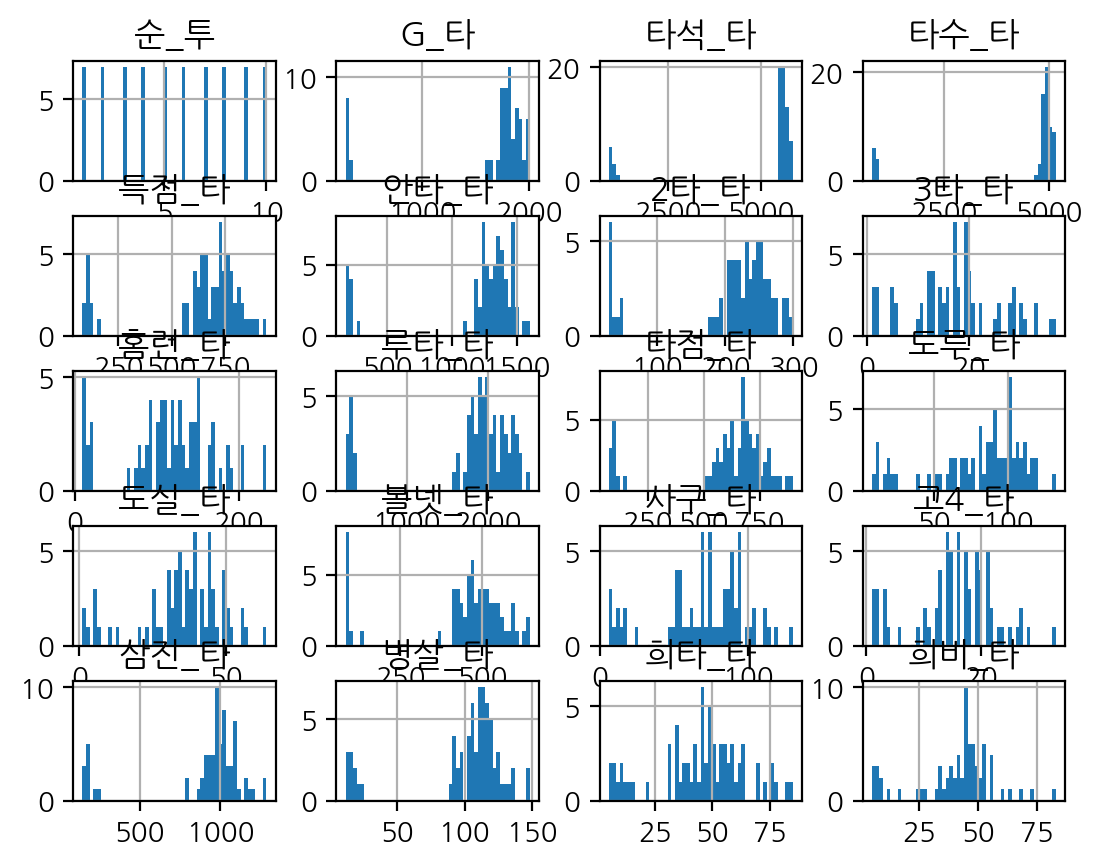

In [77]:
# G, 타석, 타수, 득점 ,안타, 2타, 루타, 타점, 볼넷, 삼진, 병살 => 정규화가 필요한가?
df.iloc[:, :20].hist(bins=50);

In [78]:
columns_to_log = ['G_타', '타석_타', '타수_타', '득점_타', '안타_타', '2타_타', '루타_타', '타점_타',
                  '볼넷_타', '삼진_타', '병살_타']
for col in columns_to_log:
    df[col] = np.log(df[col]+1)
    

In [79]:
columns_to_log = ['G_타', '타석_타', '타수_타', '득점_타', '안타_타', '2타_타', '루타_타', '타점_타', '볼넷_타', '삼진_타', '병살_타']
for col in columns_to_log:
    df[col] = np.exp(df[col])-1

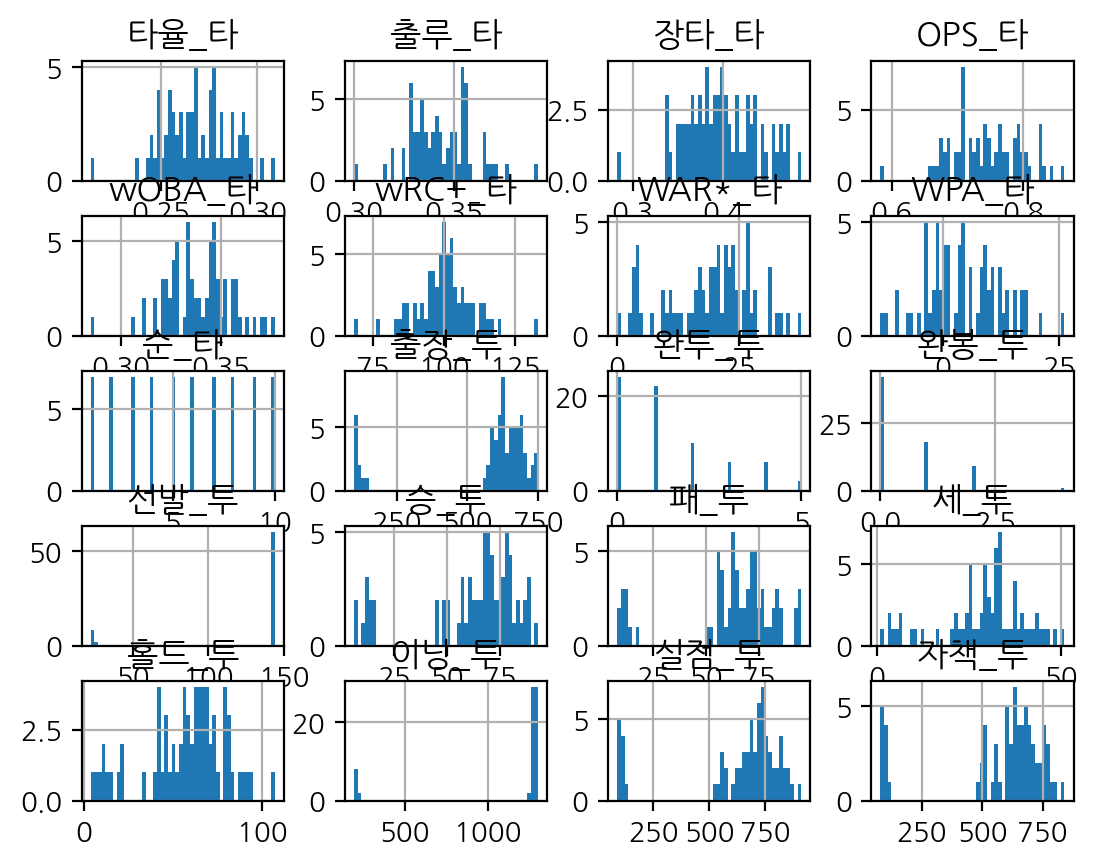

In [80]:
# 출장_투, 완투_투, 완봉_투, 선발_투, 승_투, 이닝_투, 실점_투, 자책_투

df.iloc[:, 20:40].hist(bins=50);

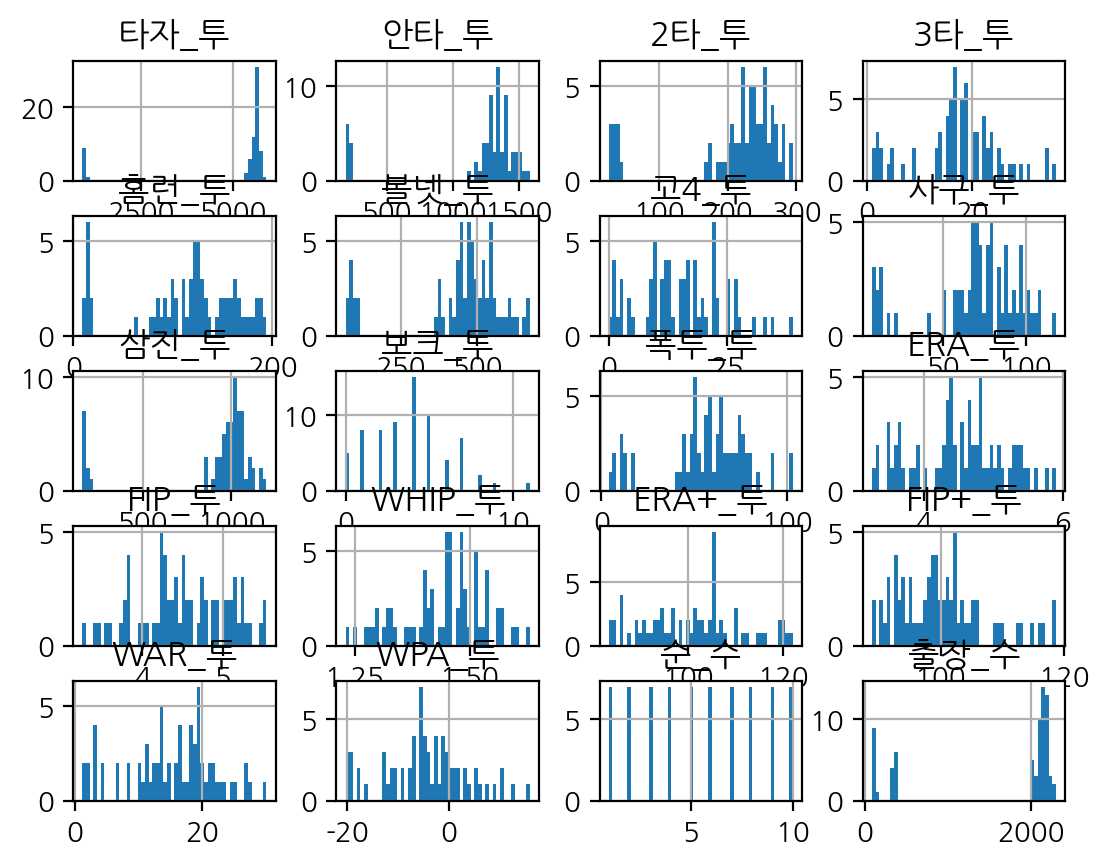

In [81]:
# 타자, 안타, 2타 삼진, 출장 

df.iloc[:, 40:60].hist(bins=50);

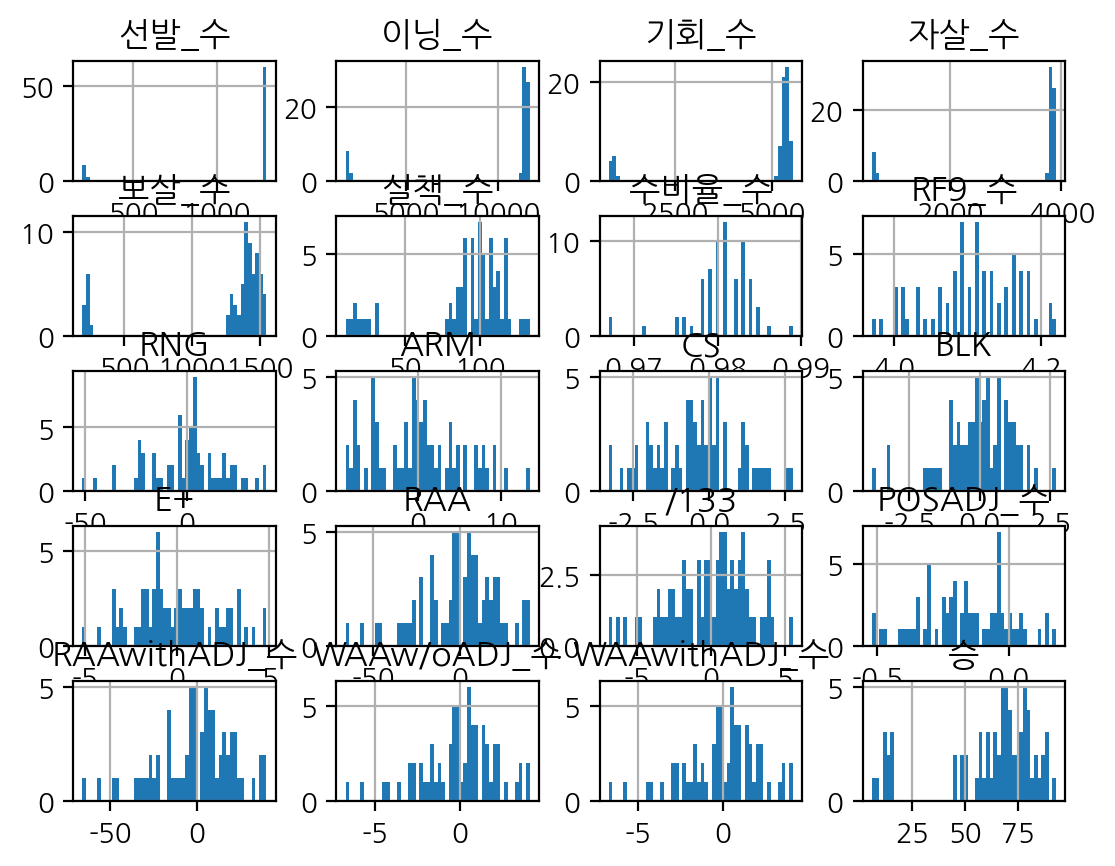

In [82]:
# 선발,이닝,기회,자살,보살,실책 => 정규화가 필요한가?

df.iloc[:, 60:80].hist(bins=50);

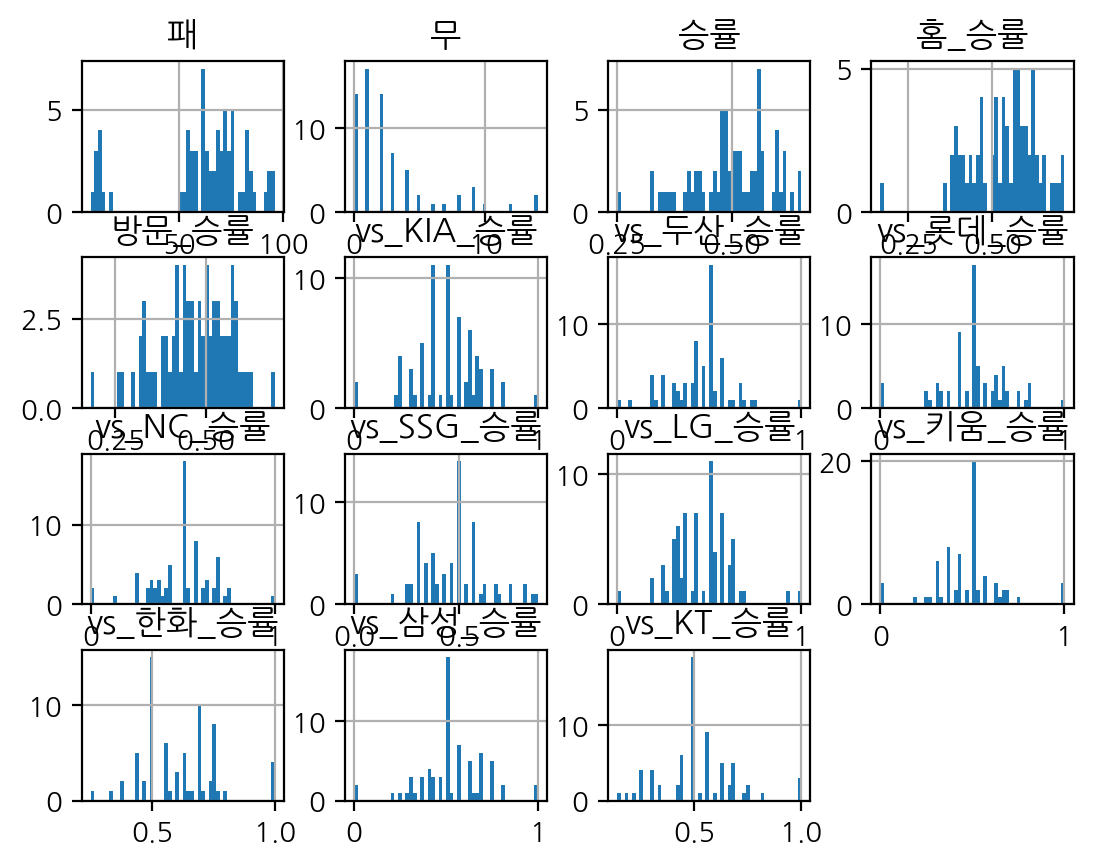

In [83]:
# 마지막 팀명은 제외
# 승,무,패는 target값이므로 정규화 하지 않아도됨
# 전체적으로 스탠다드 스케일링이 필요하다고 판단함
df.iloc[:, 80:-10].hist(bins=50);

In [84]:
# 기술통계값 확인

df.describe()

,순_투,G_타,타석_타,타수_타,득점_타,안타_타,2타_타,3타_타,홈런_타,루타_타,타점_타,도루_타,도실_타,볼넷_타,사구_타,고4_타,삼진_타,병살_타,희타_타,희비_타,타율_타,출루_타,장타_타,OPS_타,wOBA_타,wRC+_타,WAR*_타,WPA_타,순_타,출장_투,완투_투,완봉_투,선발_투,승_투,패_투,세_투,홀드_투,이닝_투,실점_투,자책_투,타자_투,안타_투,2타_투,3타_투,홈런_투,볼넷_투,고4_투,사구_투,삼진_투,보크_투,...,FIP+_투,WAR_투,WPA_투,순_수,출장_수,선발_수,이닝_수,기회_수,자살_수,보살_수,실책_수,수비율_수,RF9_수,RNG,ARM,CS,BLK,E+,RAA,/133,POSADJ_수,RAAwithADJ_수,WAAw/oADJ_수,WAAwithADJ_수,승,패,무,승률,홈_승률,방문_승률,vs_KIA_승률,vs_두산_승률,vs_롯데_승률,vs_NC_승률,vs_SSG_승률,vs_LG_승률,vs_키움_승률,vs_한화_승률,vs_삼성_승률,vs_KT_승률,팀명_KIA,팀명_KT,팀명_LG,팀명_NC,팀명_SSG,팀명_두산,팀명_롯데,팀명_삼성,팀명_키움,팀명_한화
count,70.00000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.00000,70.000000,70.00000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.00000,70.000000,70.000000,70.000000,70.000000,70.00000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,...,70.000000,70.000000,70.000000,70.00000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.00000,70.000000,70.000000,70.000000,70.000000,7.000000e+01,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000
mean,5.50000,1608.871429,4969.214286,4370.714286,631.085714,1186.742857,208.557143,17.285714,115.242857,1775.600000,596.071429,79.985714,35.10000,442.500000,69.70000,15.357143,894.814286,99.071429,45.328571,40.814286,0.269329,0.343786,0.399714,0.74350,0.338486,100.111429,18.863286,4.427143,5.50000,570.857143,1.342857,0.571429,126.857143,61.942857,61.928571,28.514286,57.142857,1125.040000,630.485714,574.085714,4963.614286,1185.471429,208.400000,17.257143,115.142857,442.057143,15.328571,69.571429,893.857143,3.857143,...,100.232857,15.047286,-4.438286,5.50000,1596.014286,1141.400000,10127.400000,4715.657143,3375.600000,1249.971429,90.085714,0.980471,4.10400,0.122429,0.018429,-0.410714,0.000286,-3.647876e-17,-0.270857,-0.047714,-0.164857,-0.435857,-0.003586,-0.003600,62.057143,62.057143,2.885714,0.499657,0.532699,0.465848,0.503322,0.449493,0.508861,0.489993,0.459905,0.457292,0.471519,0.610788,0.526241,0.522585,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
std,2.89302,543.209275,1644.153241,1450.045398,229.729188,409.849272,75.845884,8.756187,54.401203,637.917886,218.820112,30.902133,14.16277,153.870334,29.49446,7.142516,306.255567,35.758984,19.308121,16.366538,0.017425,0.015560,0.040102,0.05280,0.016548,10.041574,8.914651,8.145517,2.89302,193.483796,1.402748,0.826577,42.296841,23.262762,23.206896,11.610519,22.812586,374.659315,230.534838,212.630437,1657.796331,411.180299,76.544465,8.049999,51.302820,159.386313,8.816522,28.169555,302.997120,2.366957,...,7.184922,6.972437,8.250682,2.89302,871.750787,380.544553,3372.170296,1575.240160,1123.978137,426.347921,31.009930,0.003690,0.05984,18.568282,5.282809,1.358305,1.202962,2.228626e+00,22.233236,2.634483,0.164314,22.271274,2.184591,2.184696,23.123415,23.087663,3.351586,0.086045,0.100983,0.098980,0.174471,0.162662,0.179879,0.169223,0.179664,0.158778,0.184350,0.154083,0.180725,0.175853,0.302166,0.302166,0.302166,0.302166,0.302166,0.302166,0.302166,0.302166,0.302166,0.302166
min,1.00000,282.000000,886.000000,773.000000,81.000000,180.000000,29.000000,1.000000,9.000000,238.000000,77.000000,8.000000,1.00000,84.000000,6.00000,1.000000,146.000000,12.000000,5.000000,5.000000,0.214000,0.300000,0.283000,0.58300,0.285000,68.200000,0.070000,-13.540000,1.00000,99.000000,0.000000,0.000000,22.000000,6.000000,8.000000,1.000000,4.000000,195.100000,90.000000,79.000000,892.000000,187.000000,26.000000,1.000000,9.0

In [85]:
# z-score를 이용한 이상치 확인
# threshold는 이상치를 판단하기 위한 임계값. 여기서는 3.5배를 적용함
from scipy import stats

z = np.abs(stats.zscore(df))
threshold = 3.5
outlier_indices = np.where(z > threshold)
outlier_indices

(array([26, 60, 61, 69], dtype=int64), array([31, 66, 66, 83], dtype=int64))

In [86]:
# 확인 결과, 굳이 제거하지 않아도 되겠다고 판단했음
print(df.iloc[[26, 60, 61, 69], [31, 66]])

    완봉_투  수비율_수
26   4.0  0.980
60   0.0  0.967
61   0.0  0.967
69   0.0  0.980


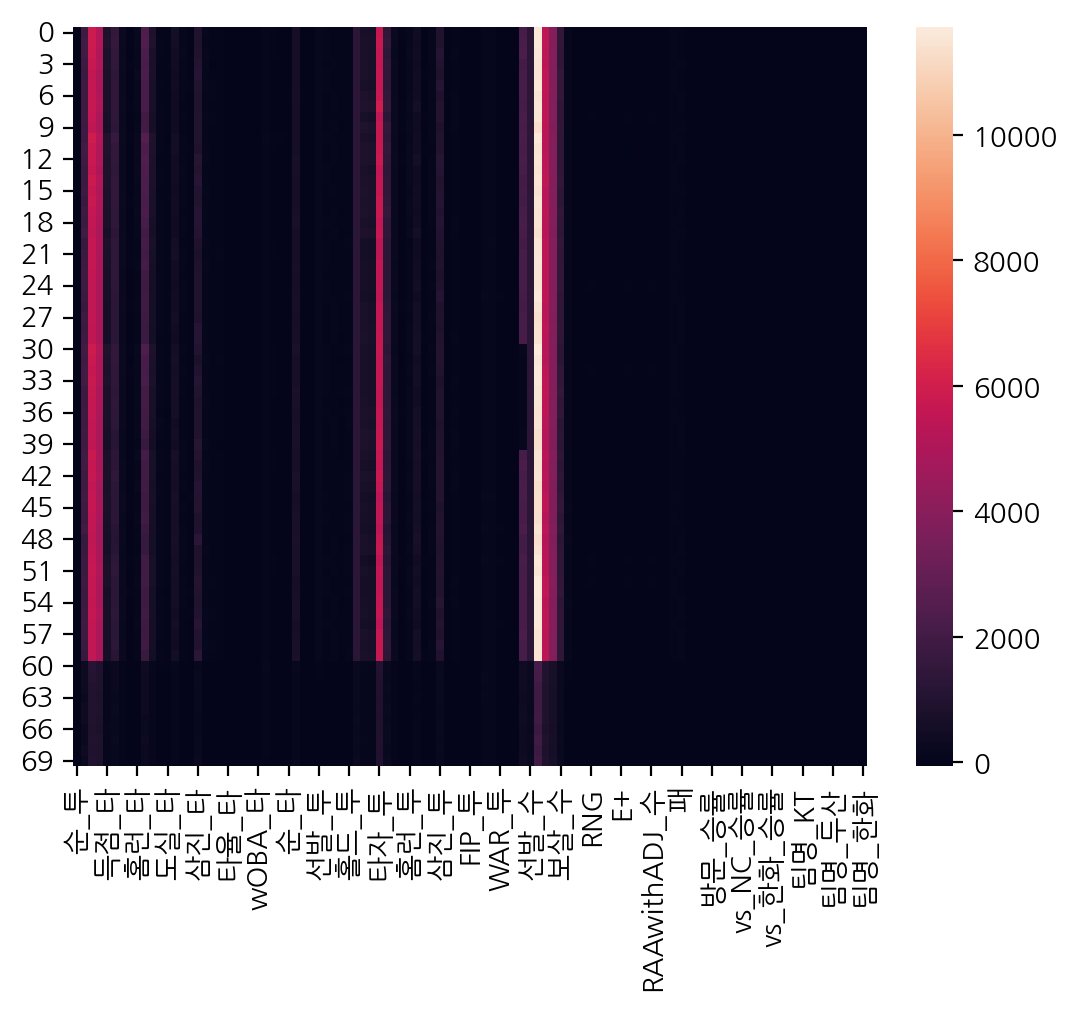

In [87]:
sns.heatmap(df);

In [88]:
df.corr()

,순_투,G_타,타석_타,타수_타,득점_타,안타_타,2타_타,3타_타,홈런_타,루타_타,타점_타,도루_타,도실_타,볼넷_타,사구_타,고4_타,삼진_타,병살_타,희타_타,희비_타,타율_타,출루_타,장타_타,OPS_타,wOBA_타,wRC+_타,WAR*_타,WPA_타,순_타,출장_투,완투_투,완봉_투,선발_투,승_투,패_투,세_투,홀드_투,이닝_투,실점_투,자책_투,타자_투,안타_투,2타_투,3타_투,홈런_투,볼넷_투,고4_투,사구_투,삼진_투,보크_투,...,FIP+_투,WAR_투,WPA_투,순_수,출장_수,선발_수,이닝_수,기회_수,자살_수,보살_수,실책_수,수비율_수,RF9_수,RNG,ARM,CS,BLK,E+,RAA,/133,POSADJ_수,RAAwithADJ_수,WAAw/oADJ_수,WAAwithADJ_수,승,패,무,승률,홈_승률,방문_승률,vs_KIA_승률,vs_두산_승률,vs_롯데_승률,vs_NC_승률,vs_SSG_승률,vs_LG_승률,vs_키움_승률,vs_한화_승률,vs_삼성_승률,vs_KT_승률,팀명_KIA,팀명_KT,팀명_LG,팀명_NC,팀명_SSG,팀명_두산,팀명_롯데,팀명_삼성,팀명_키움,팀명_한화
순_투,1.000000,-0.035639,-0.044404,-0.030934,-0.239848,-0.125908,-0.135170,-0.266034,-0.235785,-0.164591,-0.247948,-0.073031,0.139540,-0.124156,-0.193032,-0.206554,0.099167,-0.035934,0.012324,-0.219616,-0.548406,-0.707167,-4.999258e-01,-0.589713,-0.757715,-0.889207,-0.640476,-0.569774,0.395671,0.027367,-0.039284,-0.030303,-2.605639e-03,-0.322805,0.314623,-0.215734,-0.104528,-0.015244,0.122015,0.114266,0.009499,0.032852,0.064596,0.028626,0.090909,0.098628,0.041763,0.107769,-0.008498,9.735695e-02,...,-0.346629,-0.263204,-0.343809,0.196537,-0.009962,-0.002501,-0.015309,-0.013048,-0.015368,-0.015463,0.106783,-0.034620,0.015069,-0.266131,-0.123726,-0.087795,-0.370336,-0.339174,-0.311032,-0.232957,0.061585,-0.310036,-0.320281,-0.320383,-0.325833,0.319177,0.016442,-0.681353,-0.580394,-0.587129,-0.158546,-0.387259,-0.295803,-0.389837,-0.530575,-0.209330,-0.343977,-0.182579,-0.302552,-0.252094,0.024868,0.074605,-0.091184,-0.174078,-0.107762,-0.273551,0.091184,0.207235,-0.174078,0.422760
G_타,-0.035639,1.000000,0.987001,0.985793,0.938984,0.967088,0.926510,0.640540,0.780733,0.948819,0.936052,0.798195,0.766101,0.920789,0.800214,0.771211,0.936847,0.938692,0.766138,0.806554,0.356454,0.251191,4.827706e-01,0.441576,0.241812,0.036657,0.714438,0.277456,-0.011578,0.956128,0.361338,0.278140,9.865154e-01,0.886473,0.859744,0.773414,0.755356,0.986475,0.926045,0.920462,0.985394,0.964274,0.907698,0.699580,0.814513,0.896015,0.619117,0.817087,0.962397,4.480397e-01,...,0.010713,0.722522,-0.230674,-0.022193,0.547694,0.986493,0.986482,0.984773,0.986488,0.972564,0.896884,0.376910,0.328746,0.009969,0.027429,-0.076198,-0.032106,0.019365,0.010405,0.018175,-0.362769,0.007752,0.011934,0.011925,0.885085,0.857536,0.332401,0.035087,-0.023404,0.102581,0.060114,-0.055218,0.246798,0.024536,0.259032,0.100261,-0.078294,-0.302701,0.061860,-0.236544,-0.003276,0.048289,0.021182,0.037164,-0.000980,0.019416,-0.007955,-0.026939,-0.035768,-0.051132
타석_타,-0.044404,0.987001,1.000000,0.999199,0.950012,0.981759,0.947609,0.686211,0.779882,0.961789,0.946600,0.819822,0.770470,0.932263,0.803764,0.769307,0.949911,0.945576,0.756228,0.821881,0.368118,0.261028,4.887183e-01,0.448930,0.244733,0.050527,0.732886,0.274264,-0.016878,0.970090,0.364163,0.279202,9.982281e-01,0.900582,0.871567,0.806503,0.782664,0.998750,0.935502,0.929734,0.997191,0.977729,0.933859,0.732393,0.819185,0.894678,0.618190,0.843541,0.973371,4.553468e-01,...,0.006795,0.728044,-0.223776,-0.008734,0.577245,0.998203,0.998752,0.997749,0.998757,0.987082,0.911707,0.373010,0.347001,0.011999,0.008008,-0.077250,0.020545,0.018287,0.010160,0.019623,-0.361271,0.007511,0.012088,0.012090,0.899193,0.869353,0.300260,0.037239,-0.033433,0.116535,0.029917,-0.054470,0.273123,0.050959,0.221968,0.099180,-0.087601,-0.302265,0.077046,-0.217911,0.004274,-0.005907,-0.000977,0.003399,-0.004565,0.013988,-0.001356,-0.001036,0.010925,-0.018743
타수_타,-0.030934,0.985793,0.999199,1.000000,0.948607,0.984202,0.951235,0.686153,0.782731,0.964516,0.945199,0.814230,0.773775,0.918253,0.799335,0.763432,0.951170,0.946961,0.753106,0.813763,0.375434,0.249724,4.947495e-01,0.450137,0.236192,0.038384,0.723054,0.271624,-0.007448,0.967258,0.369748,0.282902,9.978543e-01,0.895380,0.879775,0.803060,0.774069,0.998418,0.941454,0.936030,0.997702,0.982961,0.941182,0.738319,0.827839,0.889003,0.614888,0.847528,0.973626,4.473841e-01,...,-0.000095,0.720363,-0.240108,0.003548,0.580694,0.997865,0.998416,0.997636,0.998420,0.

In [89]:
df.corr()[['승률', '홈_승률', '방문_승률']].nlargest(20, '승률')


,승률,홈_승률,방문_승률
승률,1.000000,0.872963,0.850304
홈_승률,0.872963,1.000000,0.489859
방문_승률,0.850304,0.489859,1.000000
wRC+_타,0.749248,0.641486,0.650303
ERA+_투,0.694960,0.586316,0.615330
wOBA_타,0.641387,0.582828,0.527383
출루_타,0.626675,0.542988,0.542647
vs_NC_승률,0.615309,0.530392,0.530085
WPA_타,0.605632,0.538749,0.508623
vs_키움_승률,0.581270,0.525909,0.464581


모델의 성능을 높이기위한 여러가지 시도
1. 다양한 모델 사용 
2. 스탠다드 스케일링 => 점수 유지 혹은 하락
3. 상관계수가 높은 피쳐 활용 => 점수하락
4. 다중공선성을 확인해서 피쳐 선택 => 점수하락
5. 모델링 후 피쳐임포턴스를 확인해서 피쳐 선택 => 점수 하락

=> 그냥 모든 피쳐를 그대로 넣고 돌리는것이 맞는것인가..

# 데이터셋 나누기

In [90]:
df.columns

Index(['순_투', 'G_타', '타석_타', '타수_타', '득점_타', '안타_타', '2타_타', '3타_타', '홈런_타',
       '루타_타',
       ...
       '팀명_KIA', '팀명_KT', '팀명_LG', '팀명_NC', '팀명_SSG', '팀명_두산', '팀명_롯데',
       '팀명_삼성', '팀명_키움', '팀명_한화'],
      dtype='object', length=105)

In [91]:
feature = ['승_투', '패_투', 'G_타', '세_투', 'WAR_투', 'ERA+_투', 'FIP+_투', '볼넷_타', 
           'POSADJ_수', '고4_타', '도실_타', 'wOBA_타', '폭투_투', '볼넷_투', 'wRC+_타', '희타_타', '삼진_타', 
           '타점_타', '출루_타', '이닝_수', '사구_타', 'WPA_타', '자살_수', '고4_투', '순_타', '2타_타', '사구_투', 
           '순_투', '출장_투', '3타_타', 'BLK', '득점_타', 'WAR*_타', '출장_수', '병살_타', '3타_투', 'WPA_투', 
           '홈런_투', 'CS', '순_수', '안타_투', '타율_타', '루타_타', 'RAAwithADJ_수', 'E+', '기회_수', '홀드_투', 
           'WHIP_투', 'ARM', '실책_수', '실점_투', 'ERA_투', '타수_타', '타자_투', '안타_타', 'WAAw/oADJ_수', '장타_타',
           '희비_타', '/133', '타석_타', 'OPS_타', '삼진_투', '도루_타', 'RNG', 'RF9_수']

features = ["출장_투", "기회_수", "타점_타", "타자_투",
            "실점_투", "세_투", "타석_타", "WAR_투", "WAR*_타", "패_투", "승_투"]

In [92]:
승무패_feature = ['안타_수', '홈런_수', '루타_수', '타점_수', '도루_실패_수',
               '도루_성공_수', '도루_시도_수', '볼넷_수', '사구_수', '삼진_수', '출루율',
               '장타율', 'OPS', 'BABIP', '타율', 'WAR', 'G', 'PA', 'AB', 'HBP']

총 13개의 target을 결정해야 하므로 target과 feature를 바꿔가며 최선의 결과값을 찾으려고 노력했음

승률, 홈_승률, 방문_승률은 연결성을 고려해서 동시에 3개의 target을 구하고

나머지 10개 상대팀과의 승률은 한번에 target으로 적용하면 예측력이 너무 떨어지므로
적절히 배분하여 승률을 구한 후 데이터에 합산함

In [93]:
# target 컬럼을 지정해줌
target_columns = ['vs_두산_승률', 'vs_롯데_승률','vs_KIA_승률',
                  'vs_NC_승률', 'vs_SSG_승률'
                  , 'vs_LG_승률', 'vs_KT_승률',
                  'vs_키움_승률', 'vs_한화_승률', 'vs_삼성_승률']
#                   ]
# target = ['승', '패', '무']
target = ['승률', '홈_승률', '방문_승률']

# X = df.drop(columns=target+target_columns)
X = df[feature]
y = df[target]

In [94]:
# 20~22년까지의 데이터를 train, 23년 데이터는 test셋으로 지정함

X_train = X.iloc[:-10]
y_train = y.iloc[:-10]
X_test = X.iloc[-10:]
y_test = y.iloc[-10:]

In [95]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [96]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape, X_test.shape, y_test.shape

((42, 65), (18, 65), (42, 3), (18, 3), (10, 65), (10, 3))

In [97]:
# 스케일러는 결과값에 따라 쓸지 말지를 결정함

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

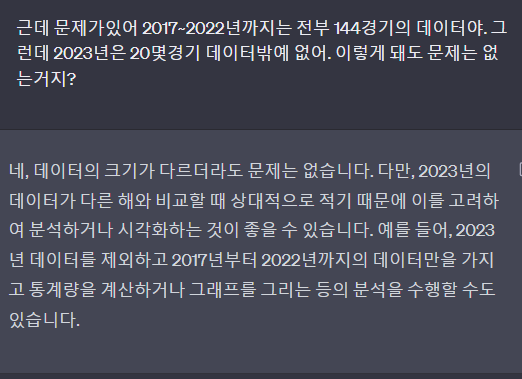

In [98]:
# # 다중공선성 확인

# from statsmodels.stats.outliers_influence import variance_inflation_factor

# # VIF 계산
# vif = pd.DataFrame()
# vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
# vif["feature"] = X.columns

# high_vif = vif[vif['VIF Factor'] >= 10000000]
# print(high_vif)

# 모델 학습

## REF를 적용한 랜덤포레스트

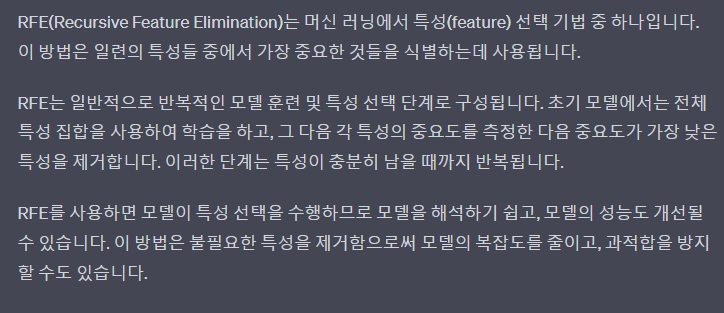

In [99]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV

# 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

# 랜덤포레스트 모델 초기화
rf = RandomForestRegressor(random_state=42)

# RFE로 특성 선택하기
selector = RFE(estimator=rf, n_features_to_select=20, step=1)
selector.fit(X_train_scaled, y_train)

# 선택된 특성만 사용하여 데이터 변환하기
X_train_selected = selector.transform(X_train_scaled)
X_valid_selected = selector.transform(X_valid_scaled)
X_test_selected = selector.transform(X_test_scaled)

# 하이퍼파라미터 설정
params = {'n_estimators': [10, 50, 100, 200],
          'max_depth': [None, 10, 30, 50],
          'max_features': [3, 6, 9, 12],
          'min_samples_split': [2, 5, 10],
          'min_samples_leaf': [1, 2, 4]}

# 랜덤서치를 사용하여 최적의 하이퍼파라미터 탐색
search = RandomizedSearchCV(rf, param_distributions=params, n_iter=100,
                            cv=5, n_jobs=-1, random_state=42)

search.fit(X_train_selected, y_train)

# 최적의 하이퍼파라미터 출력
print("Best parameters:", search.best_params_)
print("Best validation R2 score:", search.best_score_)

# 최적의 하이퍼파라미터로 모델 재학습
rf_selected = RandomForestRegressor(**search.best_params_, random_state=42)
rf_selected.fit(X_train_selected, y_train)

# 검증셋 예측
y_pred = rf_selected.predict(X_valid_selected)

# 검증셋 평가
score = r2_score(y_valid, y_pred)
print(f"valid R2 score: {score:.4f}")

# 테스트셋 예측
y_pred_test = rf_selected.predict(X_test_selected)

Best parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 12, 'max_depth': None}
Best validation R2 score: 0.7777628193156421
valid R2 score: 0.8054


In [100]:
y_pred_test

array([[0.48417   , 0.52653848, 0.4413967 ],
       [0.48425   , 0.52601787, 0.44211048],
       [0.4818    , 0.52485613, 0.43843955],
       [0.485     , 0.52594851, 0.44375567],
       [0.4765    , 0.51700902, 0.4355485 ],
       [0.48333   , 0.52598117, 0.44031374],
       [0.47701   , 0.51720936, 0.43653765],
       [0.47259   , 0.50958889, 0.43516409],
       [0.47937   , 0.52297038, 0.43547747],
       [0.46609   , 0.50690032, 0.42508357]])

## REF를 적용한 XGboost

In [101]:
import xgboost as xgb
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV

# XGB 모델 초기화
xgb_model = xgb.XGBRegressor(random_state=42)

# RFE로 특성 선택하기
selector = RFE(estimator=xgb_model, n_features_to_select=20, step=1)
selector.fit(X_train, y_train)

# 선택된 특성만 사용하여 데이터 변환하기
X_train_selected = selector.transform(X_train)
X_valid_selected = selector.transform(X_valid)
X_test_selected = selector.transform(X_test)

# 하이퍼파라미터 설정
params = {'n_estimators': [10, 50, 100, 200],
          'max_depth': [3, 5, 7, 10],
          'learning_rate': [0.01, 0.05, 0.1, 0.2],
          'subsample': [0.5, 0.7, 0.9, 1.0],
          'colsample_bytree': [0.5, 0.7, 0.9, 1.0],
          'gamma': [0, 0.1, 0.5, 1, 5]}

# 랜덤서치를 사용하여 최적의 하이퍼파라미터 탐색
search = RandomizedSearchCV(xgb_model, param_distributions=params, n_iter=100,
                            cv=5, n_jobs=-1, random_state=42)

search.fit(X_train_selected, y_train)

# 최적의 하이퍼파라미터 출력
print("Best parameters:", search.best_params_)
print("Best validation R2 score:", search.best_score_)

# 최적의 하이퍼파라미터로 모델 재학습
xgb_model_selected = xgb.XGBRegressor(**search.best_params_, random_state=42)
xgb_model_selected.fit(X_train_selected, y_train)

# 검증셋 예측
y_pred = xgb_model_selected.predict(X_valid_selected)

# 검증셋 평가
score = r2_score(y_valid, y_pred)
print(f"valid R2 score: {score:.4f}")

# 테스트셋 예측
y_pred_test_xgb = xgb_model_selected.predict(X_test_selected)

Best parameters: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.5}
Best validation R2 score: 0.7440967985284443
valid R2 score: 0.7835


In [102]:
y_pred_test_xgb

array([[0.5017439 , 0.49546093, 0.4260629 ],
       [0.4918017 , 0.4781568 , 0.42661825],
       [0.48858634, 0.4683721 , 0.40095633],
       [0.48999542, 0.5017623 , 0.40898183],
       [0.4895457 , 0.47611552, 0.4086102 ],
       [0.48836315, 0.46899718, 0.40094402],
       [0.48959863, 0.47514153, 0.42700997],
       [0.48858634, 0.4683721 , 0.40095633],
       [0.48835194, 0.48749787, 0.40243673],
       [0.48579443, 0.4662081 , 0.38532412]], dtype=float32)

## 랜덤 포레스트

In [103]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# 랜덤포레스트 모델 초기화
rf = RandomForestRegressor(random_state=42)

# 하이퍼파라미터 설정
params = {'n_estimators': [10, 50, 100, 200],
          'max_depth': [None, 10, 30, 50],
          'max_features': [3, 6, 9, 12],
          'min_samples_split': [2, 5, 10],
          'min_samples_leaf': [1, 2, 4]}

# 랜덤서치를 사용하여 최적의 하이퍼파라미터 탐색
from sklearn.model_selection import RandomizedSearchCV

search = RandomizedSearchCV(rf, param_distributions=params, n_iter=100,
                            cv=5, n_jobs=-1, random_state=42)

search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
print("Best parameters:", search.best_params_)
print("Best validation R2 score:", search.best_score_)

# 최적의 하이퍼파라미터로 모델 재학습
rf = RandomForestRegressor(**search.best_params_, random_state=42)
rf.fit(X_train, y_train)

# 검증셋 예측
y_pred = rf.predict(X_valid)

# 검증셋 평가
score = r2_score(y_valid, y_pred)
print(f"valid R2 score: {score:.4f}")

Best parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 12, 'max_depth': None}
Best validation R2 score: 0.6914562209448294
valid R2 score: 0.7552


In [104]:
y_pred_test = rf.predict(X_test_scaled)
y_pred_test

C:\Users\신하진\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


array([[0.45364   , 0.49538628, 0.41134272],
       [0.43674   , 0.47777706, 0.39508881],
       [0.43674   , 0.47777706, 0.39508881],
       [0.43783   , 0.47991193, 0.39516996],
       [0.43572   , 0.47649928, 0.39434709],
       [0.43674   , 0.47777706, 0.39508881],
       [0.43549   , 0.47663817, 0.39372408],
       [0.43597   , 0.47832859, 0.39301203],
       [0.43658   , 0.47877304, 0.39380522],
       [0.43783   , 0.47991193, 0.39516996]])

In [105]:
team_names = ['LG', 'NC', '키움', 'SSG', 'KT', '두산', '롯데', '삼성', 'KIA', '한화']

data = np.array([[0.47840833, 0.51249611, 0.44400851],
       [0.50016833, 0.53960891, 0.45999259],
       [0.50016833, 0.53960891, 0.45999259],
       [0.51256833, 0.55540848, 0.4691166 ],
       [0.48451833, 0.53640394, 0.43126078],
       [0.48661833, 0.52736406, 0.44511775],
       [0.484235  , 0.54266411, 0.42453804],
       [0.462185  , 0.51477679, 0.40834014],
       [0.49226833, 0.54693243, 0.43674271],
       [0.44931167, 0.50413904, 0.39307227]])

aa = pd.DataFrame(data, columns=['승률', '홈_승률', '원정_승률'])
aa['팀명'] = team_names
aa
aa.to_csv('data/add.csv')

In [106]:
importances = rf.feature_importances_
feature_names = features

importance_list = list(zip(feature_names, importances))
importance_list.sort(key=lambda x: x[1])

for feature, importance in importance_list:
    print(f"{feature}: {importance:.4f}")

타점_타: 0.0026
WAR*_타: 0.0032
승_투: 0.0039
패_투: 0.0046
WAR_투: 0.0069
타자_투: 0.0167
실점_투: 0.0208
타석_타: 0.0213
세_투: 0.0956
기회_수: 0.1764
출장_투: 0.1832


In [107]:
# 피쳐 중요도 출력
importances = rf.feature_importances_
for feature, importance in sorted(zip(X_train.columns, importances), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {importance}")

승_투: 0.18319609045164678
패_투: 0.1763832428003786
ERA+_투: 0.09556345691375176
wRC+_타: 0.05652662061669081
WAR*_타: 0.042749170762679076
순_투: 0.02750935193393721
타석_타: 0.023970639733401872
출루_타: 0.023404392756147654
FIP+_투: 0.021277438154262526
WAR_투: 0.020842826870433546
순_타: 0.019202803251471487
WPA_투: 0.017608607776971298
WPA_타: 0.017353701598524743
RAAwithADJ_수: 0.016911347891362963
세_투: 0.01665394442205806
타자_투: 0.011344095377484882
이닝_수: 0.011175702496635551
/133: 0.011118512108518558
WHIP_투: 0.010682530961800892
WAAw/oADJ_수: 0.008750501297674938
홀드_투: 0.008017457475773504
wOBA_타: 0.00793019129556357
실점_투: 0.007478883363978659
순_수: 0.0069116675323047895
볼넷_타: 0.006881124577775682
E+: 0.00650058438236774
기회_수: 0.006193075735357049
고4_투: 0.0058721386384033595
볼넷_투: 0.005675205533692743
타점_타: 0.005579776094142301
득점_타: 0.005567851241769645
OPS_타: 0.0052535463734888896
CS: 0.005122038245349415
홈런_투: 0.0047830731050832135
3타_타: 0.004635829985389896
타수_타: 0.004589420190376894
고4_타: 0.0045

In [108]:
# 테스트셋 예측
y_pred_test = rf.predict(X_test_scaled)
y_pred_test

C:\Users\신하진\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


array([[0.45364   , 0.49538628, 0.41134272],
       [0.43674   , 0.47777706, 0.39508881],
       [0.43674   , 0.47777706, 0.39508881],
       [0.43783   , 0.47991193, 0.39516996],
       [0.43572   , 0.47649928, 0.39434709],
       [0.43674   , 0.47777706, 0.39508881],
       [0.43549   , 0.47663817, 0.39372408],
       [0.43597   , 0.47832859, 0.39301203],
       [0.43658   , 0.47877304, 0.39380522],
       [0.43783   , 0.47991193, 0.39516996]])

## XGboost

In [109]:
import xgboost as xgb
from sklearn.metrics import r2_score

# XGBoost 모델 초기화
xgb_model = xgb.XGBRegressor(random_state=42)

# 하이퍼파라미터 설정
params = {'n_estimators': [10, 50, 100, 200],
          'max_depth': [3, 6, 9],
          'learning_rate': [0.01, 0.1, 0.5],
          'colsample_bytree': [0.3, 0.6, 0.9],
          'subsample': [0.3, 0.6, 0.9]}

# 랜덤서치를 사용하여 최적의 하이퍼파라미터 탐색
from sklearn.model_selection import RandomizedSearchCV

search = RandomizedSearchCV(xgb_model, param_distributions=params, n_iter=100,
                            cv=5, n_jobs=-1, random_state=42)

search.fit(X_train_scaled, y_train)

# 최적의 하이퍼파라미터 출력
print("Best parameters:", search.best_params_)
print("Best validation R2 score:", search.best_score_)

# 최적의 하이퍼파라미터로 모델 재학습
xgb_model = xgb.XGBRegressor(**search.best_params_, random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# 검증셋 예측
y_pred = xgb_model.predict(X_valid_scaled)

# 검증셋 평가
score = r2_score(y_valid, y_pred)
print(f"valid R2 score: {score:.4f}")

Best parameters: {'subsample': 0.3, 'n_estimators': 50, 'max_depth': 9, 'learning_rate': 0.1, 'colsample_bytree': 0.9}
Best validation R2 score: 0.7408248083414725
valid R2 score: 0.8013


## 엘라스틱 넷

In [110]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score

# 엘라스틱 넷 모델 초기화
enet = ElasticNet(random_state=42)

# 하이퍼파라미터 설정
params = {'alpha': [0.01, 0.1, 1, 10],
          'l1_ratio': [0, 0.25, 0.5, 0.75, 1],
          'max_iter': [1000, 5000, 10000]}

# 랜덤서치를 사용하여 최적의 하이퍼파라미터 탐색
from sklearn.model_selection import RandomizedSearchCV

search = RandomizedSearchCV(enet, param_distributions=params, n_iter=100,
                            cv=5, n_jobs=-1, random_state=42)

search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
print("Best parameters:", search.best_params_)
print("Best validation R2 score:", search.best_score_)

# 최적의 하이퍼파라미터로 모델 재학습
enet = ElasticNet(**search.best_params_, random_state=42)
enet.fit(X_train, y_train)

# 검증셋 예측
y_pred = enet.predict(X_valid)

# 검증셋 평가
score = r2_score(y_valid, y_pred)
print(f"valid R2 score: {score:.4f}")

C:\Users\신하진\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 60 is smaller than n_iter=100. Running 60 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters: {'max_iter': 1000, 'l1_ratio': 0.5, 'alpha': 1}
Best validation R2 score: 0.6923334611745964
valid R2 score: 0.6170


In [111]:
y_pred_test = enet.predict(X_test_scaled)

C:\Users\신하진\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but ElasticNet was fitted with feature names
  warnings.warn(


In [112]:
y_pred_test

array([[-0.3234071 ,  1.9303679 , -2.57071714],
       [-0.32338928,  1.93046293, -2.57076028],
       [-0.32355961,  1.93057328, -2.57124365],
       [-0.32352507,  1.93058534, -2.57122788],
       [-0.32362534,  1.93054998, -2.57139197],
       [-0.32361316,  1.93052494, -2.57128746],
       [-0.3237881 ,  1.93059343, -2.57177479],
       [-0.32370387,  1.93036713, -2.57135587],
       [-0.32363516,  1.93055956, -2.57143867],
       [-0.32375378,  1.93028387, -2.57137739]])

## 의사결정 나무

In [113]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

# 의사결정나무 모델 초기화
dtr = DecisionTreeRegressor(random_state=42)

# 하이퍼파라미터 설정
params = {'max_depth': [None, 10, 20, 30],
          'min_samples_split': [2, 5, 10],
          'min_samples_leaf': [1, 2, 4, 8],
          'max_features': [None, 'sqrt', 'log2']}

# 랜덤서치를 사용하여 최적의 하이퍼파라미터 탐색
from sklearn.model_selection import RandomizedSearchCV

search = RandomizedSearchCV(dtr, param_distributions=params, n_iter=100,
                            cv=5, n_jobs=-1, random_state=42)

search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
print("Best parameters:", search.best_params_)
print("Best validation R2 score:", search.best_score_)

# 최적의 하이퍼파라미터로 모델 재학습
dtr = DecisionTreeRegressor(**search.best_params_, random_state=42)
dtr.fit(X_train, y_train)

# 검증셋 예측
y_pred = dtr.predict(X_valid)

# 검증셋 평가
score = r2_score(y_valid, y_pred)
print(f"valid R2 score: {score:.4f}")

Best parameters: {'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 10}
Best validation R2 score: 0.6102858770249123
valid R2 score: 0.7142


## 릿지 

In [114]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score

# Ridge 모델 초기화
ridge = Ridge(random_state=42)

# 하이퍼파라미터 후보들 정의
params = {
    'alpha': [0.01, 0.1, 1, 10, 100],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
    'max_iter': [1000, 5000, 10000]
}

# 랜덤 서치를 사용하여 최적의 하이퍼파라미터 탐색
search = RandomizedSearchCV(ridge, param_distributions=params, n_iter=100,
                            cv=5, n_jobs=-1, random_state=42)

search.fit(X_train_scaled, y_train)

# 최적의 하이퍼파라미터 출력
print("Best parameters:", search.best_params_)
print("Best validation R2 score:", search.best_score_)

# 최적의 하이퍼파라미터로 모델 재학습
ridge = Ridge(**search.best_params_, random_state=42)
ridge.fit(X_train_scaled, y_train)

# 검증셋 예측
y_pred = ridge.predict(X_valid_scaled)

# 검증셋 평가
score = r2_score(y_valid, y_pred)
print(f"valid R2 score: {score:.4f}")

Best parameters: {'solver': 'sparse_cg', 'max_iter': 1000, 'alpha': 100}
Best validation R2 score: 0.7503882056783876
valid R2 score: 0.7461


## 라쏘

In [115]:
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV

# 라쏘 모델 초기화
lasso = Lasso(random_state=42)

# 하이퍼파라미터 설정
params = {'alpha': [0.01, 0.1, 1, 10],
          'max_iter': [1000, 5000, 10000]}

# 랜덤서치를 사용하여 최적의 하이퍼파라미터 탐색
search = RandomizedSearchCV(lasso, param_distributions=params, n_iter=100,
                            cv=5, n_jobs=-1, random_state=42)

search.fit(X_train_scaled, y_train)

# 최적의 하이퍼파라미터 출력
print("Best parameters:", search.best_params_)
print("Best validation R2 score:", search.best_score_)

# 최적의 하이퍼파라미터로 모델 재학습
lasso = Lasso(**search.best_params_, random_state=42)
lasso.fit(X_train_scaled, y_train)

# 검증셋 예측
y_pred = lasso.predict(X_valid_scaled)

# 검증셋 평가
score = r2_score(y_valid, y_pred)
print(f"valid R2 score: {score:.4f}")

Best parameters: {'max_iter': 1000, 'alpha': 0.01}
Best validation R2 score: 0.8129263049973876
valid R2 score: 0.7954


C:\Users\신하진\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 12 is smaller than n_iter=100. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


모델 학습 결과(중간회고)

1. 팀 데이터만으로도 모델은 정상적으로 작동한다.

2. 경기수를 144경기로 어떻게 지정해줘야하는지 고민했었는데 따로 지정하지 않아도 기존의 train 데이터의 144경기가 그대로 반영되는듯 보인다.

3. MSE가 높게 나온 이유는 23년 데이터는 20경기 내외로 치뤄졌고, 예측값은 144경기의 예측이므로 MSE값은 높을 수 밖에없다.(틀린건 아닌것 같음)

4. 승,무,패가 실수로 출력되는데 실제 정답은 정수형으로 출력되야하기 때문에 반올림 혹은 오름,내림을 해야하는데 이렇게 하는것이 올바른 방법인가? => 그냥 실수로 값을 내는것이 맞는것 같다.(정확성을 위해)

5. target을 10개이상 예측해야하는데 이럴때 한번에 예측하면 모델의 성능이 떨어진다. 나눠서 모델을 돌려도 괜찮은가? => 일단 챗gpt는 괜찮다는데 target을 바꾸면 feature들의 가중치가 변해서 조금 달라지지않나 => 상관없는것 같다. 어차피 머신러닝 자체가 에측하는것이기 때문에 정답이 없음